# Projet 4 : Anticipez les besoins en consommation de bâtiments

Notebook d'analyse exploratoire des données

# Sommaire
 - <a href="#C1">Importation des éléments nécessaires</a>
 - <a href="#C2">Fonctions</a>
 - <a href="#C3">Analyse des données</a>
 - <a href="#C4">Nettoyage des données</a>
     - <a href="#C4.1">Traitement des données manquantes</a>
     - <a href="#C4.2">Traitement des outliers</a>
     - <a href="#C4.3">Tests de cohérence</a>
     - <a href="#C4.4">Traitement des surfaces</a>
 - <a href="#C5">Transformation de données</a>
     - <a href="#C5.1">Calcul des variables de proportion</a>
     - <a href="#C5.2">Traitement des données qualitatives</a>
     - <a href="#C5.3">Traitement des typologies détaillées</a>     
 - <a href="#C6">Jeu de données final</a>
     - <a href="#C6.1">Analyse en Composantes Principales (ACP)</a> 

# <a name="C1"> Importation des éléments nécessaires

In [1]:
# Importation des librairies nécessaires
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics

from sklearn import linear_model, kernel_ridge, svm, neighbors
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import plotly.graph_objects as go
import plotly.offline as pyo

# Librairies pour ACP
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn import decomposition
from matplotlib.collections import LineCollection

import datetime

In [2]:
# Importation des données dans un DataFrame
data_raw = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [3]:
# Paramétrer l'affichage des résultats
pd.set_option('display.max_rows',70)
pd.set_option('display.max_columns',70)
pd.options.display.float_format = "{:,.4f}".format

# <a name="C2"> Fonctions

In [4]:
# Fonctions pour passer en NaN les valeurs aberrantes (ici inférieures à 0)
def mistakes(df,var):
    mask_0 = df[var] < 0
    df.loc[mask_0, var] = np.NaN

In [5]:
# Fonction de traitement des outliers en fonction des quartiles
def outliers(df,var):
    # calculer les quartiles
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQ = Q3-Q1
    mini = Q1-1.5*IQ
    maxi = Q3+1.5*IQ
    # mettre les outliers à NaN
    mask_mini = df[var] < mini
    df.loc[mask_mini, var] = np.NaN
    mask_maxi = df[var] > maxi
    df.loc[mask_maxi, var] = np.NaN

In [6]:
# Fonctions pour l'ACP
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# <a name="C3"> Analyse des données

In [7]:
print(data_raw.shape)
data_raw.head()

(3376, 46)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,"98,101.0000",0659000030,7,DOWNTOWN,47.6122,-122.3380,1927,1.0000,12,88434,0,88434,Hotel,Hotel,"88,434.0000",NaN,NaN,NaN,NaN,NaN,60.0000,81.7000,84.3000,182.5000,189.0000,"7,226,362.5000","7,456,910.0000","2,003,882.0000","1,156,514.2500","3,946,027.0000","12,764.5293","1,276,453.0000",False,NaN,Compliant,NaN,249.9800,2.8300
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,"98,101.0000",0659000220,7,DOWNTOWN,47.6132,-122.3339,1996,1.0000,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,"83,880.0000",Parking,"15,064.0000",Restaurant,"4,622.0000",NaN,61.0000,94.8000,97.9000,176.1000,179.4000,"8,387,933.0000","8,664,479.0000",0.0000,"950,425.1875","3,242,851.0000","51,450.8164","5,145,082.0000",False,NaN,Compliant,NaN,295.8600,2.8600
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,"98,101.0000",0659000475,7,DOWNTOWN,47.6139,-122.3381,1969,1.0000,41,956110,196718,759392,Hotel,Hotel,"756,493.0000",NaN,NaN,NaN,NaN,NaN,43.0000,96.0000,97.7000,241.9000,244.1000,"72,587,024.0000","73,937,112.0000","21,566,554.0000","14,515,435.0000","49,526,664.0000","14,938.0000","1,493,800.0000",False,NaN,Compliant,NaN,"2,089.2800",2.1900
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,"98,101.0000",0659000640,7,DOWNTOWN,47.6141,-122.3366,1926,1.0000,10,61320,0,61320,Hotel,Hotel,"61,320.0000",NaN,NaN,NaN,NaN,NaN,56.0000,110.8000,113.3000,216.2000,224.0000,"6,794,584.0000","6,946,800.5000","2,214,446.2500","811,525.3125","2,768,924.0000","18,112.1309","1,811,213.0000",False,NaN,Compliant,NaN,286.4300,4.6700
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,"98,121.0000",0659000970,7,DOWNTOWN,47.6138,-122.3405,1980,1.0000,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,"123,445.0000",Parking,"68,009.0000",Swimming Pool,0.0000,NaN,75.0000,114.8000,118.7000,211.4000,215.6000,"14,172,606.0000","14,656,503.0000",0.0000,"1,573,448.6250","5,368,607.0000","88,039.9844","8,803,998.0000",False,NaN,Compliant,NaN,505.0100,2.8800


In [8]:
data_raw.describe()
# Les commentaires sont toujours absents, il existe des valeurs aberrantes (négatives ou visiblement trop élevées)

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,"3,376.0000","3,376.0000","3,360.0000","3,376.0000","3,376.0000","3,376.0000","3,376.0000","3,368.0000","3,376.0000","3,376.0000","3,376.0000","3,376.0000","3,356.0000","1,679.0000",596.0000,"2,533.0000","3,369.0000","3,370.0000","3,367.0000","3,367.0000","3,371.0000","3,370.0000","3,367.0000","3,367.0000","3,367.0000","3,367.0000","3,367.0000",0.0000,"3,367.0000","3,367.0000"
mean,"21,208.9911","2,016.0000","98,116.9491",4.4393,47.6240,-122.3348,"1,968.5732",1.1069,4.7091,"94,833.5373","8,001.5261","86,832.0113","79,177.6386","28,444.0758","11,738.6752",67.9187,54.7321,57.0338,134.2328,137.7839,"5,403,667.2945","5,276,725.7144","274,595.8982","1,086,638.9666","3,707,612.1616","13,685.0454","1,368,504.5414",NaN,119.7240,1.1759
std,"12,223.7570",0.0000,18.6152,2.1206,0.0478,0.0272,33.0882,2.1084,5.4945,"218,837.6071","32,326.7239","207,939.8119","201,703.4075","54,392.9179","29,331.1993",26.8733,56.2731,57.1633,139.2876,139.1098,"21,610,628.6276","15,938,786.4841","3,912,173.3927","4,352,478.3552","14,850,656.1390","67,097.8083","6,709,780.8349",NaN,538.8322,1.8215
min,1.0000,"2,016.0000","98,006.0000",1.0000,47.4992,-122.4142,"1,900.0000",0.0000,0.0000,"11,285.0000",0.0000,"3,636.0000","5,656.0000",0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,-2.1000,0.0000,0.0000,0.0000,"-33,826.8008","-115,417.0000",0.0000,0.0000,NaN,-0.8000,-0.0200
25%,"19,990.7500","2,016.0000","98,105.0000",3.0000,47.5999,-122.3507,"1,948.0000",1.0000,2.0000,"28,487.0000",0.0000,"27,756.0000","25,094.7500","5,000.0000","2,239.0000",53.0000,27.9000,29.4000,74.7000,78.4000,"925,128.5938","970,182.2344",0.0000,"187,422.9453","639,487.0000",0.0000,0.0000,NaN,9.4950,0.2100
50%,"23,112.0000","2,016.0000","98,115.0000",4.0000,47.6187,-122.3325,"1,975.0000",1.0000,4.0000,"44,175.0000",0.0000,"43,216.0000","39,894.0000","10,664.0000","5,043.0000",75.0000,38.6000,40.9000,96.2000,101.1000,"1,803,753.2500","1,904,452.0000",0.0000,"345,129.9063","1,177,583.0000","3,237.5376","323,754.0000",NaN,33.9200,0.6100
75%,"25,994.2500","2,016.0000","98,122.0000",7.0000,47.6571,-122.3194,"1,997.0000",1.0000,5.0000,"90,992.0000",0.0000,"84,276.2500","76,200.2500","26,640.0000","10,138.7500",90.0000,60.4000,64.2750,143.9000,148.3500,"4,222,455.2500","4,381,429.1250",0.0000,"829,317.8438","2,829,632.5000","11,890.3350","1,189,033.5000",NaN,93.9400,1.3700
max,"50,226.0000","2,016.0000","98,272.0000",7.0000,47.7339,-122.2210,"2,015.0000",111.0000,99.0000,"9,320,156.0000","512,608.0000","9,320,156.0000","9,320,156.0000","686,750.0000","459,748.0000",100.0000,834.4000,834.4000,"2,620.0000","2,620.0000","873,923,712.0000","471,613,856.0000","134,943,456.0000","192,577,488.0000","657,074,389.0000","2,979,090.0000","297,909,000.0000",NaN,"16,870.9800",34.0900


In [9]:
# Pourcentage de valeurs manquantes par colonne
round(data_raw.isnull().sum()/len(data_raw)*100,2)

OSEBuildingID                       0.0000
DataYear                            0.0000
BuildingType                        0.0000
PrimaryPropertyType                 0.0000
PropertyName                        0.0000
Address                             0.0000
City                                0.0000
State                               0.0000
ZipCode                             0.4700
TaxParcelIdentificationNumber       0.0000
CouncilDistrictCode                 0.0000
Neighborhood                        0.0000
Latitude                            0.0000
Longitude                           0.0000
YearBuilt                           0.0000
NumberofBuildings                   0.2400
NumberofFloors                      0.0000
PropertyGFATotal                    0.0000
PropertyGFAParking                  0.0000
PropertyGFABuilding(s)              0.0000
ListOfAllPropertyUseTypes           0.2700
LargestPropertyUseType              0.5900
LargestPropertyUseTypeGFA           0.5900
SecondLarge

 - Certains ZipCode sont absents, mais comme la localisation est assurée par la latitude et la longitude et le neighboorhood, je pense que nous pouvons ignorer cette variable.
 - Les NumberOfBuildings manquants pourront être remplacer par 1 ou par le mode de cette variable par défaut
 - Pour les use types (ListOfAllPropertyUseTypes, LargestPropertyUseType), il faut analyser si cela est cohérent, mais nous pourrions remplacer par le PrimaryPropertyType
 - Pour la surface principale (LargestPropertyUseTypeGFA), remplacer par la surface totale de la property
 - Il est normal d'avoir des infos manquantes sur second and third, donc à conserver
 - Analyser le contenu de YearsENERGYSTARCertified pour décider s'il faut tout simplement l'ignorer
 - Pour l'ENERGYSTARScore, le nombre de valeurs manquantes est très important, nous allons donc dans un premier temps remplacer par 0 les valeurs manquantes mais nous n'utiliserons pas cette variable dans les premiers modèles. Nous verrons ensuite s'il est opportun d'essayer de prédire ces valeurs manquantes à l'aide d'un knn.
 - Pour mesurer la consommation d'énergie nous nous intéresserons aux variables Site et non Source

In [10]:
data_raw.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

In [11]:
# Analysons les colonnes non float64
for col in data_raw.columns[data_raw.dtypes != 'float64']:
    print(col,':', len(data_raw[col].unique()))

OSEBuildingID : 3376
DataYear : 1
BuildingType : 8
PrimaryPropertyType : 24
PropertyName : 3362
Address : 3354
City : 1
State : 1
TaxParcelIdentificationNumber : 3268
CouncilDistrictCode : 7
Neighborhood : 19
YearBuilt : 113
NumberofFloors : 50
PropertyGFATotal : 3195
PropertyGFAParking : 496
PropertyGFABuilding(s) : 3193
ListOfAllPropertyUseTypes : 467
LargestPropertyUseType : 57
SecondLargestPropertyUseType : 51
ThirdLargestPropertyUseType : 45
YearsENERGYSTARCertified : 66
DefaultData : 2
ComplianceStatus : 4
Outlier : 3


In [12]:
# Les variables suivantes n'ont qu'une seule valeur possible et peuvent donc être ignorées 
# + Comments car vide 
# + OSEBuildingID car unique pour chaque immeuble
# + les variables Source car nous ne les utiliserons pas : 
columns_to_ignore = ['DataYear', 'City', 'State',
                     'Comments',
                     'OSEBuildingID', 
                     'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']

In [13]:
# quelles sont les valeurs possibles de la colonne 'BuildingType'?
print('BuildingType :', data_raw['BuildingType'].unique())
print(50*'-')
# quelles sont les valeurs possibles de la colonne 'Outlier'?
print('Outlier :', data_raw['Outlier'].unique())
print(50*'-')
# quelles sont les valeurs possibles de la colonne 'DefaultData'?
print('DefaultData :', data_raw['DefaultData'].unique())
print(50*'-')
# quelles sont les valeurs possibles de la colonne 'ComplianceStatus'?
print('ComplianceStatus :', data_raw['ComplianceStatus'].unique())
print(50*'-')
# quelles sont les valeurs possibles de la colonne 'YearsENERGYSTARCertified'?
print('YearsENERGYSTARCertified :', data_raw['YearsENERGYSTARCertified'].unique())
print(50*'-')
# quelles sont les valeurs possibles de la colonne 'YearsENERGYSTARCertified'?
print('ENERGYSTARScore :', data_raw['ENERGYSTARScore'].unique())

BuildingType : ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']
--------------------------------------------------
Outlier : [nan 'High outlier' 'Low outlier']
--------------------------------------------------
DefaultData : [False  True]
--------------------------------------------------
ComplianceStatus : ['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']
--------------------------------------------------
YearsENERGYSTARCertified : [nan '2016' '2014' '2012' '20172015'
 '2017201620152014201320122011201020092008' '201020092007' '201720102007'
 '20162015' '20152014201220112009' '201220092008'
 '201620152014201320112010200920072000' '201620092008' '201620142012'
 '20162015201420122008'
 '2016201520142013201220112010200920082007200620052004' '201520142013'
 '2014201320112010200920082007' '2016201520142013'
 '2017201620152014201320112008' '2017201620152014

# <a name="C4"> Nettoyage des données

In [14]:
# Retirons d'ores-et-déjà les bâtiments à usage d'habitation car nous nous concentrons sur les bâtiments non résidentiels
mask = data_raw['BuildingType'].str.contains('Multifamily')
data = data_raw[~mask]
data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,"1,668.0000","1,668.0000","1,652.0000","1,668.0000","1,668.0000","1,668.0000","1,668.0000","1,666.0000","1,668.0000","1,668.0000","1,668.0000","1,668.0000","1,662.0000",855.0000,353.0000,"1,094.0000","1,665.0000","1,665.0000","1,666.0000","1,666.0000","1,666.0000","1,665.0000","1,666.0000","1,666.0000","1,666.0000","1,666.0000","1,666.0000",0.0000,"1,666.0000","1,666.0000"
mean,"16,336.3465","2,016.0000","98,116.8196",4.3567,47.6161,-122.3329,"1,961.9137",1.1687,4.1211,"118,842.7242","12,897.9790","105,944.7452","98,764.6859","36,804.1606","14,923.1399",65.4497,72.1588,74.5685,175.8299,178.0909,"8,437,933.2166","8,064,790.4376","512,572.5650","1,712,629.7825","5,843,492.8194","19,708.4464","1,970,844.6417",NaN,184.9733,1.6078
std,"13,835.2925",0.0000,18.4304,2.1910,0.0482,0.0246,32.7418,2.9314,6.5634,"297,362.2123","42,274.5112","284,211.5741","276,711.0634","69,845.2610","36,790.5566",28.4929,74.0481,75.0284,185.9321,185.9187,"30,243,803.3914","22,038,776.2633","5,513,943.6823","6,095,171.5235","20,796,725.2271","93,708.1365","9,370,813.6552",NaN,751.9760,2.3369
min,1.0000,"2,016.0000","98,006.0000",1.0000,47.4992,-122.4118,"1,900.0000",0.0000,0.0000,"11,285.0000",0.0000,"3,636.0000","5,656.0000",0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,-2.1000,0.0000,0.0000,0.0000,"-33,826.8008","-115,417.0000",0.0000,0.0000,NaN,-0.8000,-0.0200
25%,582.7500,"2,016.0000","98,105.0000",2.0000,47.5855,-122.3433,"1,930.0000",1.0000,1.0000,"29,477.7500",0.0000,"28,475.2500","25,527.5000","5,350.0000","2,663.0000",48.0000,33.7000,35.4000,76.4500,79.3250,"1,229,290.8438","1,294,615.2500",0.0000,"211,408.3243","721,325.5000",0.0000,0.0000,NaN,19.9675,0.3500
50%,"21,143.5000","2,016.0000","98,109.0000",4.0000,47.6123,-122.3329,"1,965.0000",1.0000,2.0000,"49,289.5000",0.0000,"47,391.5000","43,770.5000","12,000.0000","5,931.0000",73.0000,51.9000,53.9000,130.9500,134.1500,"2,554,947.2500","2,685,146.5000",0.0000,"472,415.3438","1,611,881.0000","4,982.6301","498,263.0000",NaN,49.5800,0.8800
75%,"24,602.2500","2,016.0000","98,125.0000",7.0000,47.6497,-122.3217,"1,989.0000",1.0000,4.0000,"105,325.0000",0.0000,"94,759.7500","91,983.7500","31,881.0000","12,941.0000",89.0000,81.7000,85.2000,203.9500,205.7000,"6,913,348.5000","7,109,712.5000",0.0000,"1,420,746.9375","4,847,588.7500","15,200.0017","1,520,000.2500",NaN,142.3825,1.8900
max,"50,226.0000","2,016.0000","98,199.0000",7.0000,47.7339,-122.2586,"2,015.0000",111.0000,99.0000,"9,320,156.0000","512,608.0000","9,320,156.0000","9,320,156.0000","686,750.0000","459,748.0000",100.0000,834.4000,834.4000,"2,620.0000","2,620.0000","873,923,712.0000","471,613,856.0000","134,943,456.0000","192,577,488.0000","657,074,389.0000","2,979,090.0000","297,909,000.0000",NaN,"16,870.9800",34.0900


In [15]:
# Comptons le nombre d'immeuble par type
data['BuildingType'].value_counts()

NonResidential        1460
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [16]:
# Nombre d'individus identifiés à exclure
data['Outlier'].value_counts()

Low outlier     15
High outlier     2
Name: Outlier, dtype: int64

In [17]:
# Nombre de fois ou des données par défaut ont été utilisées pour compléter des données manquantes
data['DefaultData'].value_counts()

False    1580
True       88
Name: DefaultData, dtype: int64

In [18]:
# Contient l'info des données par défaut + lorsque les données sont manquantes ou non conformes
data['ComplianceStatus'].value_counts()

Compliant                       1548
Error - Correct Default Data      88
Non-Compliant                     18
Missing Data                      14
Name: ComplianceStatus, dtype: int64

In [19]:
# Pour le moment conservons les données par défaut, mais retirons les données non compliant et manquantes
data = data[~data['ComplianceStatus'].isin(['Non-Compliant', 'Missing Data'])]
data.shape

(1636, 46)

In [20]:
# Retirons les individus flaggés comme outliers
data = data[~data['Outlier'].isin(['Low outlier', 'High outlier'])]
data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,"1,634.0000","1,634.0000","1,618.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,630.0000",847.0000,351.0000,"1,083.0000","1,634.0000","1,633.0000","1,634.0000","1,634.0000","1,634.0000","1,633.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000",0.0000,"1,634.0000","1,634.0000"
mean,"16,399.3905","2,016.0000","98,116.7831",4.3580,47.6161,-122.3329,"1,962.0600",1.1695,4.1554,"119,157.4510","13,124.4853","106,032.9657","98,880.2049","36,214.0157","14,923.3345",65.1911,73.0700,75.5685,177.9677,180.2703,"8,552,841.1367","8,172,161.9004","522,610.7058","1,731,445.1119","5,907,690.7222","19,996.2993","1,999,629.9333",NaN,187.7245,1.6315
std,"13,822.9595",0.0000,18.4059,2.1916,0.0482,0.0245,32.6975,2.9584,6.6235,"298,599.4586","42,666.0492","285,238.3553","278,259.0651","66,472.5537","36,887.6050",28.3765,73.7390,74.7089,184.3889,184.3451,"30,503,698.1705","22,207,399.5732","5,567,235.3232","6,143,975.7310","20,963,245.1829","94,582.9659","9,458,296.5993",NaN,758.9431,2.3518
min,1.0000,"2,016.0000","98,006.0000",1.0000,47.4992,-122.4118,"1,900.0000",0.0000,0.0000,"11,285.0000",0.0000,"3,636.0000","5,656.0000",0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,-2.1000,0.0000,0.0000,0.0000,"-33,826.8008","-115,417.0000",0.0000,0.0000,NaN,-0.8000,-0.0200
25%,586.5000,"2,016.0000","98,105.0000",2.0000,47.5853,-122.3432,"1,930.0000",1.0000,1.0000,"29,404.2500",0.0000,"28,404.0000","25,558.2500","5,404.0000","2,649.0000",48.0000,34.4000,36.6000,78.7000,81.7250,"1,267,712.0938","1,342,448.8750",0.0000,"216,831.4492","739,829.0000",0.0000,0.0000,NaN,20.8700,0.3600
50%,"21,174.5000","2,016.0000","98,109.0000",4.0000,47.6124,-122.3329,"1,966.0000",1.0000,2.0000,"49,246.0000",0.0000,"47,226.0000","43,638.0000","12,000.0000","5,931.0000",73.0000,52.2000,54.6000,132.3000,135.6000,"2,617,531.0000","2,756,929.5000",0.0000,"480,630.7500","1,639,912.0000","5,161.7898","516,179.0000",NaN,50.2450,0.8900
75%,"24,602.7500","2,016.0000","98,124.7500",7.0000,47.6497,-122.3218,"1,989.0000",1.0000,4.0000,"105,775.0000",0.0000,"94,936.0000","92,004.5000","31,795.5000","12,670.5000",89.0000,82.4000,86.2000,205.2000,206.8000,"6,978,706.1250","7,251,589.0000",0.0000,"1,451,198.0000","4,951,487.7500","15,290.1658","1,529,016.5000",NaN,144.6950,1.9100
max,"50,226.0000","2,016.0000","98,199.0000",7.0000,47.7339,-122.2586,"2,015.0000",111.0000,99.0000,"9,320,156.0000","512,608.0000","9,320,156.0000","9,320,156.0000","639,931.0000","459,748.0000",100.0000,834.4000,834.4000,"2,620.0000","2,620.0000","873,923,712.0000","471,613,856.0000","134,943,456.0000","192,577,488.0000","657,074,389.0000","2,979,090.0000","297,909,000.0000",NaN,"16,870.9800",34.0900


In [21]:
# Il existe des données négatives sur la consommation d'énergie et l'émission de GES, analysons plus en détail
data[data['Electricity(kBtu)'] < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,"98,122.0000",7234600195,3,CENTRAL,47.6143,-122.3126,2013,1.0000,6,52000,0,52000,Office,Office,"48,159.0000",NaN,NaN,NaN,NaN,NaN,100.0000,7.1000,5.0000,2.0000,-2.1000,"342,726.0938","240,132.0938",0.0000,"-33,826.8008","-115,417.0000",0.0000,0.0000,False,NaN,Compliant,NaN,-0.8000,-0.0200


In [22]:
# Il pourrait s'agir d'un bâtiment qui produit de l'énergie, ce cas étant isolé, je préfère l'exclure
# Listons les colonnes dont les données doivent être positives
columns_positives_figures = ['YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

# Appliquons notre fonction de mise à nulle des valeurs aberrantes
for col in columns_positives_figures:
    mistakes(data,col)
data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,"1,634.0000","1,634.0000","1,618.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,630.0000",847.0000,351.0000,"1,083.0000","1,634.0000","1,633.0000","1,634.0000","1,633.0000","1,634.0000","1,633.0000","1,634.0000","1,633.0000","1,633.0000","1,634.0000","1,634.0000",0.0000,"1,633.0000","1,633.0000"
mean,"16,399.3905","2,016.0000","98,116.7831",4.3580,47.6161,-122.3329,"1,962.0600",1.1695,4.1554,"119,157.4510","13,124.4853","106,032.9657","98,880.2049","36,214.0157","14,923.3345",65.1911,73.0700,75.5685,177.9677,180.3820,"8,552,841.1367","8,172,161.9004","522,610.7058","1,732,526.1113","5,911,379.0919","19,996.2993","1,999,629.9333",NaN,187.8399,1.6326
std,"13,822.9595",0.0000,18.4059,2.1916,0.0482,0.0245,32.6975,2.9584,6.6235,"298,599.4586","42,666.0492","285,238.3553","278,259.0651","66,472.5537","36,887.6050",28.3765,73.7390,74.7089,184.3889,184.3463,"30,503,698.1705","22,207,399.5732","5,567,235.3232","6,145,702.3485","20,969,136.4020","94,582.9659","9,458,296.5993",NaN,759.1613,2.3522
min,1.0000,"2,016.0000","98,006.0000",1.0000,47.4992,-122.4118,"1,900.0000",0.0000,0.0000,"11,285.0000",0.0000,"3,636.0000","5,656.0000",0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000
25%,586.5000,"2,016.0000","98,105.0000",2.0000,47.5853,-122.3432,"1,930.0000",1.0000,1.0000,"29,404.2500",0.0000,"28,404.0000","25,558.2500","5,404.0000","2,649.0000",48.0000,34.4000,36.6000,78.7000,81.8000,"1,267,712.0938","1,342,448.8750",0.0000,"217,258.7969","741,287.0000",0.0000,0.0000,NaN,20.9000,0.3600
50%,"21,174.5000","2,016.0000","98,109.0000",4.0000,47.6124,-122.3329,"1,966.0000",1.0000,2.0000,"49,246.0000",0.0000,"47,226.0000","43,638.0000","12,000.0000","5,931.0000",73.0000,52.2000,54.6000,132.3000,135.7000,"2,617,531.0000","2,756,929.5000",0.0000,"480,858.5000","1,640,689.0000","5,161.7898","516,179.0000",NaN,50.3200,0.8900
75%,"24,602.7500","2,016.0000","98,124.7500",7.0000,47.6497,-122.3218,"1,989.0000",1.0000,4.0000,"105,775.0000",0.0000,"94,936.0000","92,004.5000","31,795.5000","12,670.5000",89.0000,82.4000,86.2000,205.2000,206.8000,"6,978,706.1250","7,251,589.0000",0.0000,"1,455,813.5000","4,967,236.0000","15,290.1658","1,529,016.5000",NaN,144.7900,1.9100
max,"50,226.0000","2,016.0000","98,199.0000",7.0000,47.7339,-122.2586,"2,015.0000",111.0000,99.0000,"9,320,156.0000","512,608.0000","9,320,156.0000","9,320,156.0000","639,931.0000","459,748.0000",100.0000,834.4000,834.4000,"2,620.0000","2,620.0000","873,923,712.0000","471,613,856.0000","134,943,456.0000","192,577,488.0000","657,074,389.0000","2,979,090.0000","297,909,000.0000",NaN,"16,870.9800",34.0900


In [23]:
# Ajoutons aux colonnes à ne pas prendre en compte DefaultData (car info contenu dans ComplianceStatus) et Outlier
columns_to_ignore.append('DefaultData')
columns_to_ignore.append('Outlier')
# Nous pouvons aussi ignorer le ZipCode car certaines valeurs sont manquantes et la localisation est déjà connue grâce à la latitude et al longitude
columns_to_ignore.append('ZipCode')
# De même pour TaxParcelIdentificationNumber
columns_to_ignore.append('TaxParcelIdentificationNumber')
# Ajoutons YearsENERGYSTARCertified qui est trop souvent vide
columns_to_ignore.append('YearsENERGYSTARCertified')
columns_to_ignore

['DataYear',
 'City',
 'State',
 'Comments',
 'OSEBuildingID',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'DefaultData',
 'Outlier',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'YearsENERGYSTARCertified']

## <a name="C4.1"> Traitement des données manquantes

In [24]:
# Analysons les property types
mask = data['LargestPropertyUseType'].isnull()
data[mask].shape
data[mask]
# On peut s'appuyer sur ListOfAllPropertyUseTypes pour récupérer la première valeur (jusqu'à la virgule)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,2811 NW Market Street,Seattle,WA,"98,107.0000",1175001235,6,BALLARD,47.6684,-122.3931,"1,946.0000",2.0000,2.0000,"111,445.0000",0.0000,"111,445.0000","Fitness Center/Health Club/Gym, Office, Other ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.8000,51.0000,103.0000,106.4000,"5,697,472.5000","6,076,957.0000",0.0000,"881,452.0000","3,007,514.0000","26,899.5820","2,689,958.0000",False,NaN,Compliant,NaN,163.8300,1.4700
1147,21103,2016,NonResidential,Hotel,Palladian Hotel,2000 Second Avenue,Seattle,WA,"98,121.0000",1977201140,7,DOWNTOWN,47.6120,-122.3417,"1,910.0000",1.0000,8.0000,"61,721.0000",0.0000,"61,721.0000",Hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0000,52.2000,53.5000,150.4000,154.4000,"2,897,079.7500","2,968,429.7500",0.0000,"742,846.3750","2,534,592.0000","3,624.8752","362,488.0000",False,NaN,Compliant,NaN,36.9200,0.6000
2414,25568,2016,NonResidential,Small- and Mid-Sized Office,Talon Northlake LLC,1341 N Northlake Way,Seattle,WA,"98,103.0000",4088804565,4,LAKE UNION,47.6475,-122.3409,"2,008.0000",1.0000,4.0000,"48,350.0000",0.0000,"48,350.0000",Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0000,72.2000,74.7000,226.6000,234.6000,"3,168,131.0000","3,280,955.5000",0.0000,"928,526.0000","3,168,131.0000",0.0000,0.0000,False,NaN,Compliant,NaN,22.0900,0.4600
2459,25711,2016,NonResidential,Restaurant,BUSH GARDEN - RESTURANT & LOUNGE,614 S MAYNARD AVE S,Seattle,WA,"98,104.0000",5247802410,2,DOWNTOWN,47.5970,-122.3247,"1,913.0000",1.0000,3.0000,"28,800.0000",0.0000,"28,800.0000",Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.2000,32.5000,62.0000,62.8000,"899,924.1875","935,833.1875",0.0000,"118,085.2969","402,907.0000","4,970.1699","497,017.0000",False,NaN,Compliant,NaN,29.2100,1.0100


In [25]:
# Remplacer les valeurs manquantes de LargestPropertyUseType par la première de ListOfAllPropertyUseTypes
mask = data['LargestPropertyUseType'].isnull()
data.loc[mask, 'LargestPropertyUseType'] = data.loc[mask, 'ListOfAllPropertyUseTypes'].str.split(',', n=2, expand=True)[0]

In [26]:
# Vérification
mask = data['LargestPropertyUseType'].isnull()
data[mask].shape
data[mask]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


In [27]:
# Pour les surfaces Second et Third Largest, considérons une surface de 0 lorsqu'elles ne sont pas renseignées
# Puis une typologie 'Unknown' lorsque la surface est nulle

# Mettons les surfaces second et third à 0
mask_0 = data['SecondLargestPropertyUseTypeGFA'].isnull()
data.loc[mask_0, 'SecondLargestPropertyUseTypeGFA'] = 0

mask_1 = data['ThirdLargestPropertyUseTypeGFA'].isnull()
data.loc[mask_1, 'ThirdLargestPropertyUseTypeGFA'] = 0

# Passer en 'Unknown' les cas où la surface est nulle
mask_2 = data['SecondLargestPropertyUseTypeGFA'] == 0
print(len(data[mask_2]))
data.loc[mask_2, 'SecondLargestPropertyUseType'] = 'Unknown'

mask_3 = data['ThirdLargestPropertyUseTypeGFA'] == 0
print(len(data[mask_3]))
data.loc[mask_3, 'ThirdLargestPropertyUseType'] = 'Unknown'

864
1307


In [28]:
# Existe-t-il maintenant des cas où les typologies Second and Third ne sont pas renseignées? => non
mask_2 = data['SecondLargestPropertyUseType'].isnull()
print(len(data[mask_2]))

mask_3 = data['ThirdLargestPropertyUseType'].isnull()
print(len(data[mask_3]))

0
0


In [29]:
# Nous n'aurons plus besoin également de ListOfAllPropertyUseTypes
columns_to_ignore.append('ListOfAllPropertyUseTypes')
# Retirons également les éléments qualitatifs d'identification des immeubles comme le nom et l'adresse
columns_to_ignore.append('PropertyName')
columns_to_ignore.append('Address')
columns_to_ignore

['DataYear',
 'City',
 'State',
 'Comments',
 'OSEBuildingID',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'DefaultData',
 'Outlier',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'YearsENERGYSTARCertified',
 'ListOfAllPropertyUseTypes',
 'PropertyName',
 'Address']

In [30]:
# Analyse du contenu de 'NumberOfBuildings'
data['NumberofBuildings'].value_counts()

1.0000      1530
0.0000        52
2.0000        14
3.0000        12
5.0000         7
4.0000         4
6.0000         4
14.0000        2
8.0000         2
27.0000        1
11.0000        1
9.0000         1
7.0000         1
23.0000        1
10.0000        1
111.0000       1
Name: NumberofBuildings, dtype: int64

In [31]:
# Remplacer les valeurs vides du nombre d'immeubles par le mode (1)
mask = data['NumberofBuildings'].isnull()
data.loc[mask, 'NumberofBuildings'] = 1
mask_0 = data['NumberofBuildings'] == 0
data.loc[mask_0, 'NumberofBuildings'] = 1

In [32]:
data['NumberofBuildings'].value_counts()

1.0000      1582
2.0000        14
3.0000        12
5.0000         7
4.0000         4
6.0000         4
14.0000        2
8.0000         2
27.0000        1
11.0000        1
9.0000         1
7.0000         1
23.0000        1
10.0000        1
111.0000       1
Name: NumberofBuildings, dtype: int64

In [33]:
# Remplacer les valeurs vides du largestGFA par la GFA de la property
mask = data['LargestPropertyUseTypeGFA'].isnull()
data[mask]
data.loc[mask, 'LargestPropertyUseTypeGFA'] = data.loc[mask, 'PropertyGFATotal']

In [34]:
# Retirons les colonnes qui ne vont plus nous servir
data_clean = data.drop(columns_to_ignore, axis=1)

In [35]:
print(data_clean.shape)
data_clean.describe()

(1634, 31)


,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,"1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,083.0000","1,634.0000","1,633.0000","1,634.0000","1,633.0000","1,634.0000","1,633.0000","1,633.0000","1,634.0000","1,634.0000","1,633.0000","1,633.0000"
mean,4.3580,47.6161,-122.3329,"1,962.0600",1.2013,4.1554,"119,157.4510","13,124.4853","106,032.9657","98,791.3403","18,771.8919","3,205.6857",65.1911,73.0700,75.5685,"8,552,841.1367","8,172,161.9004","522,610.7058","1,732,526.1113","5,911,379.0919","19,996.2993","1,999,629.9333",187.8399,1.6326
std,2.1916,0.0482,0.0245,32.6975,2.9510,6.6235,"298,599.4586","42,666.0492","285,238.3553","277,927.9658","51,154.1200","18,144.5090",28.3765,73.7390,74.7089,"30,503,698.1705","22,207,399.5732","5,567,235.3232","6,145,702.3485","20,969,136.4020","94,582.9659","9,458,296.5993",759.1613,2.3522
min,1.0000,47.4992,-122.4118,"1,900.0000",1.0000,0.0000,"11,285.0000",0.0000,"3,636.0000","5,656.0000",0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2.0000,47.5853,-122.3432,"1,930.0000",1.0000,1.0000,"29,404.2500",0.0000,"28,404.0000","25,566.5000",0.0000,0.0000,48.0000,34.4000,36.6000,"1,267,712.0938","1,342,448.8750",0.0000,"217,258.7969","741,287.0000",0.0000,0.0000,20.9000,0.3600
50%,4.0000,47.6124,-122.3329,"1,966.0000",1.0000,2.0000,"49,246.0000",0.0000,"47,226.0000","43,694.5000",0.0000,0.0000,73.0000,52.2000,54.6000,"2,617,531.0000","2,756,929.5000",0.0000,"480,858.5000","1,640,689.0000","5,161.7898","516,179.0000",50.3200,0.8900
75%,7.0000,47.6497,-122.3218,"1,989.0000",1.0000,4.0000,"105,775.0000",0.0000,"94,936.0000","92,004.5000","12,863.0000",0.0000,89.0000,82.4000,86.2000,"6,978,706.1250","7,251,589.0000",0.0000,"1,455,813.5000","4,967,236.0000","15,290.1658","1,529,016.5000",144.7900,1.9100
max,7.0000,47.7339,-122.2586,"2,015.0000",111.0000,99.0000,"9,320,156.0000","512,608.0000","9,320,156.0000","9,320,156.0000","639,931.0000","459,748.0000",100.0000,834.4000,834.4000,"873,923,712.0000","471,613,856.0000","134,943,456.0000","192,577,488.0000","657,074,389.0000","2,979,090.0000","297,909,000.0000","16,870.9800",34.0900


In [36]:
# Pourcentage de valeurs manquantes par colonne après ces traitements et avant traitement des outliers
round(data_clean.isnull().sum()/len(data_clean)*100,2)

BuildingType                       0.0000
PrimaryPropertyType                0.0000
CouncilDistrictCode                0.0000
Neighborhood                       0.0000
Latitude                           0.0000
Longitude                          0.0000
YearBuilt                          0.0000
NumberofBuildings                  0.0000
NumberofFloors                     0.0000
PropertyGFATotal                   0.0000
PropertyGFAParking                 0.0000
PropertyGFABuilding(s)             0.0000
LargestPropertyUseType             0.0000
LargestPropertyUseTypeGFA          0.0000
SecondLargestPropertyUseType       0.0000
SecondLargestPropertyUseTypeGFA    0.0000
ThirdLargestPropertyUseType        0.0000
ThirdLargestPropertyUseTypeGFA     0.0000
ENERGYSTARScore                   33.7200
SiteEUI(kBtu/sf)                   0.0000
SiteEUIWN(kBtu/sf)                 0.0600
SiteEnergyUse(kBtu)                0.0000
SiteEnergyUseWN(kBtu)              0.0600
SteamUse(kBtu)                    

In [37]:
# Il y a visiblement des cas où la donnée de consommation d'énergie existe mais pas sa normalisation (Weather Normalised)
mask_0 = data_clean['SiteEnergyUseWN(kBtu)'].isnull()
data_clean[mask_0]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
563,NonResidential,Large Office,7,DOWNTOWN,47.6105,-122.3444,"1,979.0000",1.0000,7.0000,"131,143.0000","87,160.0000","43,983.0000",Office,"120,248.0000",Retail Store,"10,853.0000",Unknown,0.0000,93.0000,39.5000,NaN,"5,177,270.5000",NaN,0.0000,"1,427,645.2500","4,871,126.0000","14,160.4092","1,416,041.0000",Compliant,109.1600,0.8300


In [38]:
# Regardons également les cas où SiteEnergyUseWN(kBtu) est égal à 0
mask_1 = data_clean['SiteEnergyUseWN(kBtu)'] == 0
data_clean[mask_1]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
220,NonResidential,Large Office,7,DOWNTOWN,47.6037,-122.3345,"1,958.0000",1.0000,17.0000,"378,525.0000","84,600.0000","293,925.0000",Office,"236,827.0000",Parking,"83,311.0000",Restaurant,"14,679.0000",69.0000,105.2000,0.0000,"24,906,132.0000",0.0000,"10,921,066.0000","4,098,787.7500","13,985,064.0000",0.0000,0.0000,Compliant,940.4700,2.4800
247,NonResidential,Large Office,7,DOWNTOWN,47.6170,-122.3297,"1,988.0000",1.0000,20.0000,"497,513.0000","118,744.0000","378,769.0000",Office,"367,623.0000",Parking,"114,510.0000",Unknown,0.0000,65.0000,73.0000,0.0000,"26,823,218.0000",0.0000,0.0000,"7,796,691.0000","26,602,310.0000","2,209.0500","220,905.0000",Compliant,197.1900,0.4000
284,NonResidential,Large Office,7,DOWNTOWN,47.6092,-122.3363,"1,929.0000",1.0000,15.0000,"151,039.0000",0.0000,"151,039.0000",Office,"125,473.0000",Unknown,0.0000,Unknown,0.0000,84.0000,43.4000,0.0000,"5,446,624.0000",0.0000,"2,850,077.7500","761,004.1250","2,596,546.0000",0.0000,0.0000,Compliant,238.0900,1.5800
350,NonResidential,Small- and Mid-Sized Office,7,MAGNOLIA / QUEEN ANNE,47.6201,-122.3577,"1,971.0000",1.0000,5.0000,"88,000.0000","21,600.0000","66,400.0000",Office,"69,691.0000",Parking,"17,487.0000",Unknown,0.0000,75.0000,50.0000,0.0000,"3,484,915.5000",0.0000,0.0000,"1,021,370.1880","3,484,915.0000",0.0000,0.0000,Compliant,24.2900,0.2800
882,NonResidential,Worship Facility,6,Northwest,47.6757,-122.3285,"1,910.0000",1.0000,2.0000,"23,931.0000",0.0000,"23,931.0000",Worship Facility,"23,931.0000",Unknown,0.0000,Unknown,0.0000,88.0000,20.7000,0.0000,"496,477.3125",0.0000,0.0000,"48,966.8984","167,075.0000","3,294.0217","329,402.0000",Compliant,18.6600,0.7800
953,NonResidential,Worship Facility,4,NORTHEAST,47.6875,-122.2985,"2,000.0000",1.0000,2.0000,"31,386.0000",0.0000,"31,386.0000",Worship Facility,"30,000.0000",Unknown,0.0000,Unknown,0.0000,52.0000,37.6000,0.0000,"1,128,179.1250",0.0000,0.0000,"208,229.2969","710,478.0000","4,177.0078","417,701.0000",Compliant,27.1400,0.8600
1361,SPS-District K-12,K-12 School,5,NORTH,47.7237,-122.3068,"1,954.0000",1.0000,1.0000,"42,292.0000",0.0000,"42,292.0000",K-12 School,"43,188.0000",Unknown,0.0000,Unknown,0.0000,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Error - Correct Default Data,0.0000,0.0000
3274,Campus,University,4,NORTHEAST,47.6564,-122.3104,"1,900.0000",111.0000,0.0000,"9,320,156.0000",0.0000,"9,320,156.0000",College/University,"9,320,156.0000",Unknown,0.0000,Unknown,0.0000,NaN,93.8000,0.0000,"873,923,712.0000",0.0000,"84,985,240.0000","192,577,488.0000","657,074,389.0000",0.0000,0.0000,Compliant,"11,140.5600",1.2000
3275,NonResidential,University,4,NORTHEAST,47.6540,-122.3058,"1,969.0000",1.0000,4.0000,"58,779.0000",0.0000,"58,779.0000",College/University,"58,779.0000",Unknown,0.0000,Unknown,0.0000,NaN,85.1000,0.0000,"5,000,717.0000",0.0000,0.0000,"1,090,040.1250","3,719,217.0000",0.0000,0.0000,Compliant,25.9300,0.4400
3277,NonResidential,University,4,NORTHEAST,47.6536,-122.3061,"1,998.0000",1.0000,6.0000,"203,030.0000",0.0000,"203,030.0000",College/University,"203,030.0000",Unknown,0.0000,Unknown,0.0000,NaN,252.0000,0.0000,"51,168,308.0000",0.0000,0.0000,"8,386,463.5000","28,614,613.0000",0.0000,0.0000,Compliant,199.4800,0.9800


In [39]:
# Pour ces cas là, nous allons remplacer les données manquantes par la consommation d'énergie non normalisée
data_clean.loc[mask_0,'SiteEnergyUseWN(kBtu)'] = data_clean.loc[mask_0,'SiteEnergyUse(kBtu)']
data_clean.loc[mask_1,'SiteEnergyUseWN(kBtu)'] = data_clean.loc[mask_1,'SiteEnergyUse(kBtu)']

# vérifions
print(len(data_clean[data_clean['SiteEnergyUseWN(kBtu)'].isnull()]))
print(len(data_clean[data_clean['SiteEnergyUseWN(kBtu)'] == 0]))

0
1


## <a name="C4.2"> Traitement des outliers

In [40]:
# Excluons les données atypiques
# Listons les colonnes sur lesquelles appliquer notre traitement : 
# Je retire Buildings et Parkings car au final ça ne va trop nous servir (et c'est inclus dans PropertyTotal)
# + SourceEUI ainsi que les données non WeatherNormalised car on ne s'en servira pas 

columns_outliers = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 
                     'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 
                    'TotalGHGEmissions', 'GHGEmissionsIntensity']

# Appliquons la fonction qui va mettre à Nan les valeurs identifiées comme atypiques grâce à l'écart interquartile
for col in columns_outliers:
    outliers(data_clean,col)
data_clean.describe()

,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,"1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,582.0000","1,496.0000","1,432.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,634.0000","1,083.0000","1,634.0000","1,482.0000","1,634.0000","1,454.0000","1,520.0000","1,445.0000","1,445.0000","1,454.0000","1,454.0000","1,462.0000","1,494.0000"
mean,4.3580,47.6161,-122.3329,"1,962.0600",1.0000,2.6638,"59,731.0531","13,124.4853","106,032.9657","98,791.3403","18,771.8919","3,205.6857",65.1911,73.0700,56.7263,"8,552,841.1367","3,778,882.1017",0.0000,"696,343.9046","2,375,925.4049","7,030.0957","703,009.5688",72.3919,1.0779
std,2.1916,0.0482,0.0245,32.6975,0.0000,1.7434,"44,058.2741","42,666.0492","285,238.3553","277,927.9658","51,154.1200","18,144.5090",28.3765,73.7390,31.9799,"30,503,698.1705","3,610,384.9400",0.0000,"714,106.6589","2,436,531.9105","8,941.4728","894,147.2835",75.6873,0.9362
min,1.0000,47.4992,-122.4118,"1,900.0000",1.0000,0.0000,"11,285.0000",0.0000,"3,636.0000","5,656.0000",0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2.0000,47.5853,-122.3432,"1,930.0000",1.0000,1.0000,"27,926.7500",0.0000,"28,404.0000","25,566.5000",0.0000,0.0000,48.0000,34.4000,34.5000,"1,267,712.0938","1,259,271.3750",0.0000,"196,193.7031","669,413.0000",0.0000,0.0000,18.7450,0.3400
50%,4.0000,47.6124,-122.3329,"1,966.0000",1.0000,2.0000,"43,290.0000",0.0000,"47,226.0000","43,694.5000",0.0000,0.0000,73.0000,52.2000,51.6000,"2,617,531.0000","2,358,732.3750",0.0000,"396,033.9063","1,351,268.0000","3,620.7324","362,073.5000",43.8200,0.7800
75%,7.0000,47.6497,-122.3218,"1,989.0000",1.0000,4.0000,"75,421.7500",0.0000,"94,936.0000","92,004.5000","12,863.0000",0.0000,89.0000,82.4000,74.5000,"6,978,706.1250","5,208,596.2500",0.0000,"966,097.3750","3,296,324.0000","10,147.1497","1,014,715.0000",98.1650,1.5275
max,7.0000,47.7339,-122.2586,"2,015.0000",1.0000,8.0000,"217,603.0000","512,608.0000","9,320,156.0000","9,320,156.0000","639,931.0000","459,748.0000",100.0000,834.4000,159.7000,"873,923,712.0000","16,274,449.0000",0.0000,"3,296,889.2500","11,248,986.0000","38,203.3906","3,820,339.0000",328.9700,4.2100


In [41]:
# Le nombre d'immeuble est toujours 1 après traitement des outliers, peut-être peut-on simplement retirer cette variable
data_clean = data_clean.drop('NumberofBuildings', axis=1)

In [42]:
# Pourcentage de valeurs manquantes par colonne après traitement des outliers
round(data_clean.isnull().sum()/len(data_clean)*100,2)

BuildingType                       0.0000
PrimaryPropertyType                0.0000
CouncilDistrictCode                0.0000
Neighborhood                       0.0000
Latitude                           0.0000
Longitude                          0.0000
YearBuilt                          0.0000
NumberofFloors                     8.4500
PropertyGFATotal                  12.3600
PropertyGFAParking                 0.0000
PropertyGFABuilding(s)             0.0000
LargestPropertyUseType             0.0000
LargestPropertyUseTypeGFA          0.0000
SecondLargestPropertyUseType       0.0000
SecondLargestPropertyUseTypeGFA    0.0000
ThirdLargestPropertyUseType        0.0000
ThirdLargestPropertyUseTypeGFA     0.0000
ENERGYSTARScore                   33.7200
SiteEUI(kBtu/sf)                   0.0000
SiteEUIWN(kBtu/sf)                 9.3000
SiteEnergyUse(kBtu)                0.0000
SiteEnergyUseWN(kBtu)             11.0200
SteamUse(kBtu)                     6.9800
Electricity(kWh)                  

In [43]:
# Mettons à 0 les valeurs manquantes pour l'energystarscore
mask = data_clean['ENERGYSTARScore'].isnull()
data_clean.loc[mask, 'ENERGYSTARScore'] = 0

In [44]:
# Retirons maintenant les valeurs absentes de notre jeu de données
data_clean = data_clean.dropna()
print(data_clean.shape)
data_clean.describe()

(1154, 30)


,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,"1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000"
mean,4.0451,47.6152,-122.3329,"1,959.0373",2.4749,"53,769.6889","4,145.1837","49,624.5052","45,918.7210","6,514.4676","1,084.1179",43.9185,49.4324,52.0294,"2,396,960.2255","2,517,737.8114",0.0000,"514,256.3849","1,754,642.7930","6,377.1093","637,710.9298",46.1011,0.9787
std,2.1411,0.0517,0.0257,32.0386,1.5330,"37,962.4757","14,030.0408","32,701.6556","33,543.8541","12,533.6276","3,483.3892",38.4470,28.6862,29.6678,"2,022,274.3385","2,074,172.1692",0.0000,"526,918.5104","1,797,845.9487","7,830.5554","783,055.5442",44.4416,0.8696
min,1.0000,47.4992,-122.4118,"1,900.0000",0.0000,"11,285.0000",0.0000,"11,285.0000","5,656.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2.0000,47.5754,-122.3445,"1,929.0000",1.0000,"26,832.5000",0.0000,"26,056.2500","23,075.2500",0.0000,0.0000,0.0000,29.6000,31.3750,"1,011,741.9688","1,079,301.0938",0.0000,"170,513.0508","581,790.7500",0.0000,0.0000,14.0100,0.3100
50%,4.0000,47.6128,-122.3319,"1,962.0000",2.0000,"40,374.5000",0.0000,"38,785.5000","35,090.5000",0.0000,0.0000,50.0000,44.3000,47.2000,"1,761,974.1250","1,891,940.6875",0.0000,"317,743.7031","1,084,141.5000","3,741.5552","374,155.5005",32.7250,0.7000
75%,6.0000,47.6557,-122.3205,"1,984.0000",3.0000,"64,996.0000",0.0000,"60,687.0000","57,482.5000","8,664.2500",0.0000,82.0000,65.2000,68.6750,"3,094,758.3750","3,306,923.2500",0.0000,"655,180.9375","2,235,477.7500","9,589.3391","958,934.0000",61.9500,1.3800
max,7.0000,47.7339,-122.2586,"2,015.0000",8.0000,"213,283.0000","156,000.0000","208,981.0000","293,707.0000","108,036.0000","41,014.0000",100.0000,158.4000,158.4000,"13,424,079.0000","13,827,966.0000",0.0000,"3,020,895.5000","10,307,295.0000","38,203.3906","3,820,339.0000",260.1300,4.1500


## <a name="C4.3"> Tests de cohérence

In [45]:
# Vérifions la cohérence des données présentes : 
# On choisit de se concentrer sur les variables "Site" et non "Source" pour représenter la consommation totale d'énergie

data_check = pd.DataFrame()
data_work = data_clean.copy()

# Totaux nécessaires pour les calculs : 
# Somme de la répartition des surfaces
data_work['Use_GFA_Total'] = data_work['LargestPropertyUseTypeGFA'] + data_work['SecondLargestPropertyUseTypeGFA'] + data_work['ThirdLargestPropertyUseTypeGFA']

# Total des sources d'énergie
data_work['Total_Sources'] = data_work['Electricity(kBtu)'] + data_work['NaturalGas(kBtu)'] + data_work['SteamUse(kBtu)']

# checks (le résultat doit être 0) :
# surfaces totales
data_check['Check_Areas_base'] = data_work['PropertyGFATotal'] - data_work['PropertyGFAParking'] - data_work['PropertyGFABuilding(s)']
# répartition des surfaces
data_check['Check_Areas_Use'] = data_work['PropertyGFATotal'] - data_work['Use_GFA_Total']

# Check total des énergies
data_check['Check_Energy'] = data_work['SiteEnergyUse(kBtu)'] - data_work['Total_Sources']

# Ratios sqf
# Intensité des émissions de GES
data_check['Check_GHG_Intensity'] = data_work['GHGEmissionsIntensity'] - round(data_work['TotalGHGEmissions'] / data_work['PropertyGFATotal'] * 1000,2)
# Intensité du Site / PropertyGFATotal
data_check['Check_Site_Intensity'] = round(data_work['SiteEUI(kBtu/sf)'] - data_work['SiteEnergyUse(kBtu)'] / data_work['PropertyGFATotal'],0)
# Intensité du Site WN / PropertyGFATotal
data_check['Check_WN_Site_Intensity'] = round(data_work['SiteEUIWN(kBtu/sf)'] - data_work['SiteEnergyUseWN(kBtu)'] / data_work['PropertyGFATotal'],0)

# Intensité du Site WN / LargestPropertyUseTypeGFA
data_check['Check_WN_Site_Intensity_Largest'] =  round(data_work['SiteEUIWN(kBtu/sf)'] - data_work['SiteEnergyUseWN(kBtu)'] / data_work['LargestPropertyUseTypeGFA'],0)

# Intensité du Site WN / Use_GFA_Total
data_check['Check_WN_Site_Intensity_Use_GFA'] =  round(data_work['SiteEUIWN(kBtu/sf)'] - data_work['SiteEnergyUseWN(kBtu)'] / data_work['Use_GFA_Total'],0)

# Conversions
# Conversion kWh / kBtu
data_check['Conv_kWh_kBtu'] = round(data_work['Electricity(kBtu)'] / data_work['Electricity(kWh)'],2)
# Conversion therms / kBtu
data_check['Conv_therms_kBtu'] = round(data_work['NaturalGas(kBtu)'] / data_work['NaturalGas(therms)'],2)

# Conversion Weather Normalised pour le Site
data_check['Check_Site_WN'] = round(data_work['SiteEnergyUseWN(kBtu)'] / data_work['SiteEnergyUse(kBtu)'],2)

data_check.describe()

,Check_Areas_base,Check_Areas_Use,Check_Energy,Check_GHG_Intensity,Check_Site_Intensity,Check_WN_Site_Intensity,Check_WN_Site_Intensity_Largest,Check_WN_Site_Intensity_Use_GFA,Conv_kWh_kBtu,Conv_therms_kBtu,Check_Site_WN
count,"1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,154.0000","1,153.0000",815.0000,"1,153.0000"
mean,0.0000,252.3825,"4,606.5026",0.0000,2.8102,2.7149,-10.8735,1.8016,3.4100,100.0000,1.0618
std,0.0000,"15,397.1668","110,777.7708",0.0000,11.3575,12.2310,32.1331,9.9460,0.0000,0.0009,0.0560
min,0.0000,"-248,007.0000","-496,692.0000",0.0000,-58.0000,-85.0000,-646.0000,-139.0000,3.4100,99.9900,0.9600
25%,0.0000,0.0000,-0.1250,0.0000,0.0000,0.0000,-8.0000,0.0000,3.4100,100.0000,1.0100
50%,0.0000,0.0000,0.1875,0.0000,0.0000,0.0000,0.0000,0.0000,3.4100,100.0000,1.0500
75%,0.0000,427.2500,0.5000,0.0000,1.7500,1.0000,0.0000,-0.0000,3.4100,100.0000,1.1000
max,0.0000,"154,359.0000","3,406,054.5000",0.0000,92.0000,92.0000,79.0000,87.0000,3.4100,100.0200,1.2400


In [46]:
# Appliquons un seuil d'acceptation des écarts (liés aux arrondis par exemple)
seuil_accept = 5

# Calculons le nombre d'erreurs
nb_lignes = len(data_check)
chk_area_base = data_check[abs(data_check['Check_Areas_base']) > seuil_accept]
chk_area_use = data_check[abs(data_check['Check_Areas_Use']) > seuil_accept]
chk_energy = data_check[abs(data_check['Check_Energy']) > seuil_accept]
chk_CHG_int = data_check[abs(data_check['Check_GHG_Intensity']) > seuil_accept]
chk_site_int = data_check[abs(data_check['Check_Site_Intensity']) > seuil_accept]
chk_WN_site_int = data_check[abs(data_check['Check_WN_Site_Intensity']) > seuil_accept]
chk_WN_site_int_largest = data_check[abs(data_check['Check_WN_Site_Intensity_Largest']) > seuil_accept]
chk_WN_site_int_use = data_check[abs(data_check['Check_WN_Site_Intensity_Use_GFA']) > seuil_accept]
chk_conv_kwh = data_check[abs(data_check['Conv_kWh_kBtu'] - 3.41) > seuil_accept/100]
chk_conv_therms = data_check[abs(data_check['Conv_therms_kBtu'] - 100) > seuil_accept/100]


print('Nombre total de lignes :', nb_lignes)
print('1.Surfaces :')
print(" - Différence entre PropertyGFATotal et découpage Building / Parking :", 
      len(chk_area_base), 'soit', round(len(chk_area_base)/nb_lignes*100,2), '%')
print(" - Différence entre PropertyGFATotal et découpage par usage :", 
      len(chk_area_use), 'soit', round(len(chk_area_use)/nb_lignes*100,2), '%')

print('2.Total des énergies :')
print(" - Différence entre SiteEnergyUse(kBtu) et la somme des consommation par source d'énergie :", 
      len(chk_energy), 'soit', round(len(chk_energy)/nb_lignes*100,2), '%')

print('3.Intensités :')
print(" - Différence entre GHGEmissionsIntensity et le calcul en prenant PropertyGFATotal :", 
      len(chk_CHG_int), 'soit', round(len(chk_CHG_int)/nb_lignes*100,2), '%')
print(" - Différence entre SiteEUI(kBtu/sf) et le calcul en prenant PropertyGFATotal :", 
      len(chk_site_int), 'soit', round(len(chk_site_int)/nb_lignes*100,2), '%')
print(" - Différence entre SiteEUIWN(kBtu/sf) et le calcul en prenant PropertyGFATotal :", 
      len(chk_WN_site_int), 'soit', round(len(chk_WN_site_int)/nb_lignes*100,2), '%')
print(" - Différence entre SiteEUIWN(kBtu/sf) et le calcul en prenant LargestPropertyUseTypeGFA :", 
      len(chk_WN_site_int_largest), 'soit', round(len(chk_WN_site_int_largest)/nb_lignes*100,2), '%')
print(" - Différence entre SiteEUIWN(kBtu/sf) et le calcul en prenant Use_GFA_Total :", 
      len(chk_WN_site_int_use), 'soit', round(len(chk_WN_site_int_use)/nb_lignes*100,2), '%')

print('4.Conversions :')
print(" - Différence de taux de conversion des kWh vers les kBtu :", 
      len(chk_conv_kwh), 'soit', round(len(chk_conv_kwh)/nb_lignes*100,2), '%')
print(" - Différence de taux de conversion des therms vers les kBtu :", 
      len(chk_conv_therms), 'soit', round(len(chk_conv_therms)/nb_lignes*100,2), '%')

Nombre total de lignes : 1154
1.Surfaces :
 - Différence entre PropertyGFATotal et découpage Building / Parking : 0 soit 0.0 %
 - Différence entre PropertyGFATotal et découpage par usage : 573 soit 49.65 %
2.Total des énergies :
 - Différence entre SiteEnergyUse(kBtu) et la somme des consommation par source d'énergie : 8 soit 0.69 %
3.Intensités :
 - Différence entre GHGEmissionsIntensity et le calcul en prenant PropertyGFATotal : 0 soit 0.0 %
 - Différence entre SiteEUI(kBtu/sf) et le calcul en prenant PropertyGFATotal : 285 soit 24.7 %
 - Différence entre SiteEUIWN(kBtu/sf) et le calcul en prenant PropertyGFATotal : 295 soit 25.56 %
 - Différence entre SiteEUIWN(kBtu/sf) et le calcul en prenant LargestPropertyUseTypeGFA : 325 soit 28.16 %
 - Différence entre SiteEUIWN(kBtu/sf) et le calcul en prenant Use_GFA_Total : 149 soit 12.91 %
4.Conversions :
 - Différence de taux de conversion des kWh vers les kBtu : 0 soit 0.0 %
 - Différence de taux de conversion des therms vers les kBtu : 0

Il existe très peu de cas d'écarts sur le total de l'énergie consommé, mais regardons les plus en détail :

In [47]:
# Regardons plus en détail les cas d'écarts sur l'énergie
test_nrj = ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'Total_Sources']
data_nrj = data_work.loc[chk_energy.index, test_nrj]
data_nrj['WN ratio'] = data_nrj['SiteEnergyUseWN(kBtu)'] / data_nrj['SiteEnergyUse(kBtu)']
data_nrj['WN / total'] = data_nrj['SiteEnergyUseWN(kBtu)'] / data_nrj['Total_Sources']
data_nrj

,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),Total_Sources,WN ratio,WN / total
1105,"4,489,661.0000","4,515,744.5000","4,489,301.0000",1.0058,1.0059
2037,"2,107,743.7500","2,438,706.5000","1,815,369.0000",1.1570,1.3434
2441,"2,092,696.0000","2,136,896.0000","2,589,388.0000",1.0211,0.8253
2761,"977,230.3125","1,031,447.6250","204,995.0000",1.0555,5.0316
2791,"4,729,846.5000","4,821,852.0000","1,323,792.0000",1.0195,3.6425
3230,"1,662,054.1250","1,695,022.2500","1,631,290.0000",1.0198,1.0391
3270,"923,812.8125","961,628.6250","894,741.0000",1.0409,1.0748
3275,"5,000,717.0000","5,000,717.0000","3,719,217.0000",1.0000,1.3446


In [48]:
# Certains de ces écarts sont très importants, pour rester cohérent, je propose de modifier SiteEnergyUseWN(kBtu)
# en remplaçant par Total_Sources * WN ratio
data_work['WN ratio'] = data_work['SiteEnergyUseWN(kBtu)'] / data_work['SiteEnergyUse(kBtu)']
data_work['New_SiteEnergyUseWN(kBtu)'] = data_work['SiteEnergyUseWN(kBtu)']
data_work.loc[chk_energy.index, 'New_SiteEnergyUseWN(kBtu)'] = data_work.loc[chk_energy.index, 'Total_Sources'] * \
                data_work.loc[chk_energy.index,'WN ratio']
data_work.loc[chk_energy.index,['SiteEnergyUseWN(kBtu)', 'Total_Sources','New_SiteEnergyUseWN(kBtu)']]

,SiteEnergyUseWN(kBtu),Total_Sources,New_SiteEnergyUseWN(kBtu)
1105,"4,515,744.5000","4,489,301.0000","4,515,382.4085"
2037,"2,438,706.5000","1,815,369.0000","2,100,422.3973"
2441,"2,136,896.0000","2,589,388.0000","2,644,078.6716"
2761,"1,031,447.6250","204,995.0000","216,368.2432"
2791,"4,821,852.0000","1,323,792.0000","1,349,542.5492"
3230,"1,695,022.2500","1,631,290.0000","1,663,647.8949"
3270,"961,628.6250","894,741.0000","931,366.7725"
3275,"5,000,717.0000","3,719,217.0000","3,719,217.0000"


Il convient maintenant de se pencher sur les écarts de surface qui sont très nombreux.

## <a name="C4.4"> Traitement des surfaces

In [49]:
# Analysons plus en détail les différences entre la surface totale et le découpage par usage
print('Nombre de cas où le découpage par usage est supérieur au total :', len(chk_area_use[chk_area_use['Check_Areas_Use'] < 0]))
# Créons une colonne 'Unknown' qui contient la différence entre la surface totale et la somme du détail
data_work['Unknown'] = round(data_work['PropertyGFATotal'] - data_work['Use_GFA_Total'],0)
mask = abs(data_work['Unknown']) <= seuil_accept
data_work.loc[mask, 'Unknown'] = 0    
data_work[data_work['Unknown'] < 0]

Nombre de cas où le découpage par usage est supérieur au total : 248


,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,Use_GFA_Total,Total_Sources,WN ratio,New_SiteEnergyUseWN(kBtu),Unknown
22,SPS-District K-12,K-12 School,2,SOUTHEAST,47.5458,-122.2685,"1,961.0000",2.0000,"56,228.0000",0.0000,"56,228.0000",K-12 School,"58,916.0000",Unknown,0.0000,Unknown,0.0000,95.0000,26.1000,29.1000,"1,539,478.5000","1,713,623.5000",0.0000,"274,605.9063","936,955.0000","6,025.2290","602,523.0000",Error - Correct Default Data,38.5300,0.6900,"58,916.0000","1,539,478.0000",1.1131,"1,713,623.5000","-2,688.0000"
40,NonResidential,Small- and Mid-Sized Office,2,GREATER DUWAMISH,47.5803,-122.3113,"1,900.0000",2.0000,"52,554.0000",0.0000,"52,554.0000",Office,"51,029.0000",Other - Education,"7,849.0000",Unknown,0.0000,83.0000,50.1000,53.5000,"2,951,331.2500","3,150,635.5000",0.0000,"462,998.0000","1,579,749.0000","13,715.8203","1,371,582.0000",Compliant,83.8600,1.6000,"58,878.0000","2,951,331.0000",1.0675,"3,150,635.5000","-6,324.0000"
44,NonResidential,Large Office,7,DOWNTOWN,47.6113,-122.3366,"1,973.0000",5.0000,"168,115.0000",0.0000,"168,115.0000",Office,"103,362.0000",Retail Store,"65,676.0000",Data Center,493.0000,78.0000,56.3000,56.3000,"9,536,161.0000","9,536,161.0000",0.0000,"2,794,888.7500","9,536,160.0000",0.0000,0.0000,Compliant,66.4800,0.4000,"169,531.0000","9,536,160.0000",1.0000,"9,536,161.0000","-1,416.0000"
54,NonResidential,Hotel,7,LAKE UNION,47.6202,-122.3431,"1,997.0000",6.0000,"116,300.0000","28,200.0000","88,100.0000",Hotel,"88,490.0000",Parking,"28,300.0000",Unknown,0.0000,80.0000,65.9000,67.1000,"5,827,595.5000","5,941,927.0000",0.0000,"934,483.3125","3,188,457.0000","26,391.3809","2,639,138.0000",Compliant,162.3900,1.4000,"116,790.0000","5,827,595.0000",1.0196,"5,941,927.0000",-490.0000
66,NonResidential,Retail Store,7,LAKE UNION,47.6224,-122.3380,"1,929.0000",2.0000,"58,320.0000",0.0000,"58,320.0000",Retail Store,"72,072.0000",Unknown,0.0000,Unknown,0.0000,96.0000,14.6000,17.2000,"1,049,748.6250","1,243,027.7500",0.0000,"106,038.5000","361,803.0000","6,879.4521","687,945.0000",Compliant,39.0600,0.6700,"72,072.0000","1,049,748.0000",1.1841,"1,243,027.7500","-13,752.0000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,NonResidential,Other,4,NORTHEAST,47.6641,-122.3166,"2,014.0000",3.0000,"33,648.0000",0.0000,"33,648.0000",Parking,"83,600.0000",Automobile Dealership,"39,000.0000",Unknown,0.0000,0.0000,35.9000,35.9000,"1,399,581.6250","1,399,581.6250",0.0000,"410,193.9063","1,399,582.0000",0.0000,0.0000,Compliant,9.7600,0.2900,"122,600.0000","1,399,582.0000",1.0000,"1,399,581.6250","-88,952.0000"
3322,NonResidential,Other,2,GREATER DUWAMISH,47.5854,-122.3218,"2,015.0000",2.0000,"108,036.0000",0.0000,"108,036.0000",Parking,"202,171.0000",Automobile Dealership,"108,036.0000",Unknown,0.0000,0.0000,46.2000,49.0000,"4,991,893.5000","5,298,717.5000",0.0000,"1,099,805.2500","3,752,536.0000","12,393.5713","1,239,357.0000",Compliant,91.9800,0.8500,"310,207.0000","4,991,893.0000",1.0615,"5,298,717.5000","-202,171.0000"
3337,NonResidential,Hotel,4,LAKE UNION,47.6548,-122.3473,"2,014.0000",4.0000,"126,823.0000","41,539.0000","85,284.0000",Hotel,"88,157.0000",Parking,"41,539.0000",Unknown,0.0000,72.0000,68.5000,68.5000,"6,042,399.5000","6,042,399.5000",0.0000,"1,206,219.2500","4,115,620.0000","19,267.7910","1,926,779.0000",Compliant,131.0200,1.0300,"129,696.0000","6,042,399.0000",1.0000,"6,042,3

In [50]:
# Regardons plus en détail les cas d'écarts sur l'énergie
test_nrj = ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'Total_Sources']
data_nrj = data_work.loc[chk_energy.index, test_nrj]
data_nrj['WN ratio'] = data_nrj['SiteEnergyUseWN(kBtu)'] / data_nrj['SiteEnergyUse(kBtu)']
data_nrj['WN / total'] = data_nrj['SiteEnergyUseWN(kBtu)'] / data_nrj['Total_Sources']
data_nrj

,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),Total_Sources,WN ratio,WN / total
1105,"4,489,661.0000","4,515,744.5000","4,489,301.0000",1.0058,1.0059
2037,"2,107,743.7500","2,438,706.5000","1,815,369.0000",1.1570,1.3434
2441,"2,092,696.0000","2,136,896.0000","2,589,388.0000",1.0211,0.8253
2761,"977,230.3125","1,031,447.6250","204,995.0000",1.0555,5.0316
2791,"4,729,846.5000","4,821,852.0000","1,323,792.0000",1.0195,3.6425
3230,"1,662,054.1250","1,695,022.2500","1,631,290.0000",1.0198,1.0391
3270,"923,812.8125","961,628.6250","894,741.0000",1.0409,1.0748
3275,"5,000,717.0000","5,000,717.0000","3,719,217.0000",1.0000,1.3446


In [51]:
# Certains de ces écarts sont très importants, pour rester cohérent, je propose de modifier SiteEnergyUseWN(kBtu)
# en remplaçant par Total_Sources * WN ratio
data_work['WN ratio'] = data_work['SiteEnergyUseWN(kBtu)'] / data_work['SiteEnergyUse(kBtu)']
data_work['New_SiteEnergyUseWN(kBtu)'] = data_work['SiteEnergyUseWN(kBtu)']
data_work.loc[chk_energy.index, 'New_SiteEnergyUseWN(kBtu)'] = data_work.loc[chk_energy.index, 'Total_Sources'] * \
                data_work.loc[chk_energy.index,'WN ratio']
data_work.loc[chk_energy.index,['SiteEnergyUseWN(kBtu)', 'Total_Sources','New_SiteEnergyUseWN(kBtu)']]

,SiteEnergyUseWN(kBtu),Total_Sources,New_SiteEnergyUseWN(kBtu)
1105,"4,515,744.5000","4,489,301.0000","4,515,382.4085"
2037,"2,438,706.5000","1,815,369.0000","2,100,422.3973"
2441,"2,136,896.0000","2,589,388.0000","2,644,078.6716"
2761,"1,031,447.6250","204,995.0000","216,368.2432"
2791,"4,821,852.0000","1,323,792.0000","1,349,542.5492"
3230,"1,695,022.2500","1,631,290.0000","1,663,647.8949"
3270,"961,628.6250","894,741.0000","931,366.7725"
3275,"5,000,717.0000","3,719,217.0000","3,719,217.0000"


Stratégie de traitement des surfaces : 
 - Dans les cas où la somme du détail des surfaces est supérieure à la surface totale (Unknown <0), nous allons remplacer la surface totale par la somme du détail.
 - Dans les cas inverses la colonne 'Unknown' contiendra la surface manquante.

In [52]:
# Créons une colonne pour accueillir notre surface totale corrigée
data_work['New_PropertyGFATotal'] = data_work['PropertyGFATotal']
mask = data_work['Unknown'] < 0
data_work.loc[mask,'New_PropertyGFATotal'] = data_work['Use_GFA_Total']
data_work['Unknown'] = round(data_work['New_PropertyGFATotal'] - data_work['Use_GFA_Total'],0)

mask_2 = abs(data_work['Unknown']) <= seuil_accept
data_work.loc[mask_2, 'Unknown'] = 0
len(data_work[data_work['Unknown'] < 0])

0

In [53]:
# Résumé des surfaces
data_work[['PropertyGFATotal', 'Use_GFA_Total', 'Unknown', 'New_PropertyGFATotal']]

,PropertyGFATotal,Use_GFA_Total,Unknown,New_PropertyGFATotal
22,"56,228.0000","58,916.0000",0.0000,"58,916.0000"
23,"88,592.0000","88,592.0000",0.0000,"88,592.0000"
25,"67,224.0000","67,224.0000",0.0000,"67,224.0000"
29,"68,410.0000","47,994.0000","20,416.0000","68,410.0000"
32,"87,262.0000","63,403.0000","23,859.0000","87,262.0000"
...,...,...,...,...
3370,"18,261.0000","18,261.0000",0.0000,"18,261.0000"
3371,"12,294.0000","12,294.0000",0.0000,"12,294.0000"
3372,"16,000.0000","16,000.0000",0.0000,"16,000.0000"
3374,"14,101.0000","13,586.0000",515.0000,"14,101.0000"


In [54]:
# Recalculons l'Intensité du Site WN par rapport à notre nouvelle surface 'New_PropertyGFATotal'
data_check['Check_New_WN_Site_Intensity'] = round(data_work['SiteEUIWN(kBtu/sf)'] - data_work['SiteEnergyUseWN(kBtu)'] / data_work['New_PropertyGFATotal'],0)
chk_new_WN_site_int = data_check[abs(data_check['Check_New_WN_Site_Intensity']) > seuil_accept]

print(" - Différence entre SiteEUIWN(kBtu/sf) et le calcul en prenant New_PropertyGFATotal :", 
      len(chk_new_WN_site_int), 'soit', round(len(chk_new_WN_site_int)/nb_lignes*100,2), '%')

 - Différence entre SiteEUIWN(kBtu/sf) et le calcul en prenant New_PropertyGFATotal : 249 soit 21.58 %


# <a name="C5"> Transformation des données

 - Maintenant que nous avons une surface cohérente, il convient de recalculer les 2 ratios que nous tenteront d'expliquer par la suite : SiteEUIWN(kBtu/sf) et GHGEmissionsIntensity

Afin d'expliquer ces ratios, nous utiliseront les variables suivantes : 
 - localisation (longitude, latitude, neighboorhood, district)
 - année de construction
 - nombre d'étage et taille totale
 - type d'immeuble et usage principal
 - typologies et répartition des surfaces
 - mix énergétique

## <a name="C5.1"> Calcul des variables de proportion

In [55]:
# alculer le mix énergétique
data_work['mix_elec'] = data_work['Electricity(kBtu)'] / data_work['Total_Sources']

data_work['mix_gas'] = data_work['NaturalGas(kBtu)'] / data_work['Total_Sources']

data_work['mix_steam'] = data_work['SteamUse(kBtu)'] / data_work['Total_Sources']

# Recalcul des ratios énergie et émissions (qui seront nos 2 targets)
data_work['New_SiteEUIWN(kBtu/sf)'] = data_work['New_SiteEnergyUseWN(kBtu)'] / data_work['New_PropertyGFATotal']
data_work['New_GHGEmissionsIntensity'] = round(data_work['TotalGHGEmissions'] / data_work['New_PropertyGFATotal'] * 1000,2)

# Puis calculer la proportion de surface par usage que nous pourront utiliser
data_work['sqf_use1'] = data_work['LargestPropertyUseTypeGFA'] / data_work['New_PropertyGFATotal']
data_work['sqf_use2'] = data_work['SecondLargestPropertyUseTypeGFA'] / data_work['New_PropertyGFATotal']
data_work['sqf_use3'] = data_work['ThirdLargestPropertyUseTypeGFA'] / data_work['New_PropertyGFATotal']
data_work['sqf_use4'] = data_work['Unknown'] / data_work['New_PropertyGFATotal']

In [56]:
# A-t-on des valeurs manquantes (division par 0)?
data_work.isnull().sum()

BuildingType                       0
PrimaryPropertyType                0
CouncilDistrictCode                0
Neighborhood                       0
Latitude                           0
Longitude                          0
YearBuilt                          0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseType             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseType       0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseType        0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEUI(kBtu/sf)                   0
SiteEUIWN(kBtu/sf)                 0
SiteEnergyUse(kBtu)                0
SiteEnergyUseWN(kBtu)              0
SteamUse(kBtu)                     0
Electricity(kWh)                   0
Electricity(kBtu)                  0
NaturalGas(therms)                 0
NaturalGas(kBtu)                   0
C

In [57]:
# Oui, il s'agit d'un échantillon sans consommation d'énergie renseignée, nous pouvons l'ignorer
data_work[data_work['WN ratio'].isnull()]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,Use_GFA_Total,Total_Sources,WN ratio,New_SiteEnergyUseWN(kBtu),Unknown,New_PropertyGFATotal,mix_elec,mix_gas,mix_steam,New_SiteEUIWN(kBtu/sf),New_GHGEmissionsIntensity,sqf_use1,sqf_use2,sqf_use3,sqf_use4
1361,SPS-District K-12,K-12 School,5,NORTH,47.7237,-122.3068,"1,954.0000",1.0000,"42,292.0000",0.0000,"42,292.0000",K-12 School,"43,188.0000",Unknown,0.0000,Unknown,0.0000,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,Error - Correct Default Data,0.0000,0.0000,"43,188.0000",0.0000,NaN,0.0000,0.0000,"43,188.0000",NaN,NaN,NaN,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


In [58]:
# Retirons les NaN (certainement une division par 0)
data_work = data_work.dropna()
print(data_work.shape)
data_work.describe()

(1153, 45)


,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Use_GFA_Total,Total_Sources,WN ratio,New_SiteEnergyUseWN(kBtu),Unknown,New_PropertyGFATotal,mix_elec,mix_gas,mix_steam,New_SiteEUIWN(kBtu/sf),New_GHGEmissionsIntensity,sqf_use1,sqf_use2,sqf_use3,sqf_use4
count,"1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000"
mean,4.0442,47.6151,-122.3329,"1,959.0416",2.4761,"53,779.6435","4,148.7788","49,630.8647","45,921.0893","6,520.1176","1,085.0581",43.8699,49.4753,52.0745,"2,399,039.1155","2,519,921.4522",0.0000,"514,702.4009","1,756,164.5995","6,382.6402","638,264.0182",46.1411,0.9795,"53,526.2650","2,394,428.6177",1.0620,"2,515,184.2548","2,492.5880","56,018.8560",0.7123,0.2877,0.0000,47.6422,0.9513,0.8377,0.1054,0.0196,0.0373
std,2.1418,0.0516,0.0256,32.0522,1.5331,"37,977.4420","14,035.5971","32,715.1320","33,558.3134","12,537.5960","3,484.7543",38.4282,28.6616,29.6410,"2,021,917.8586","2,073,744.7643",0.0000,"526,929.1807","1,797,882.3559","7,831.6979","783,169.7985",44.4401,0.8695,"38,602.5247","2,020,585.2534",0.0559,"2,072,615.1788","9,399.5038","40,554.0074",0.2651,0.2651,0.0000,27.1605,0.8460,0.2051,0.1466,0.0543,0.0976
min,1.0000,47.4992,-122.4118,"1,900.0000",0.0000,"11,285.0000",0.0000,"11,285.0000","5,656.0000",0.0000,0.0000,0.0000,1.4000,0.0000,"57,133.1992","58,114.1992",0.0000,"1,798.9000","6,138.0000",0.0000,0.0000,0.4000,0.0100,"8,223.0000","57,133.0000",0.9627,"58,114.1992",0.0000,"11,285.0000",0.0045,0.0000,0.0000,1.4546,0.0100,0.1865,0.0000,0.0000,0.0000
25%,2.0000,47.5753,-122.3446,"1,929.0000",1.0000,"26,830.0000",0.0000,"26,050.0000","23,067.0000",0.0000,0.0000,0.0000,29.6000,31.6000,"1,011,965.3750","1,080,492.3750",0.0000,"170,954.2031","583,296.0000",0.0000,0.0000,14.1300,0.3100,"26,373.0000","1,011,965.0000",1.0094,"1,080,492.3750",0.0000,"27,760.0000",0.4987,0.0000,0.0000,29.1518,0.3000,0.6766,0.0000,0.0000,0.0000
50%,4.0000,47.6128,-122.3320,"1,962.0000",2.0000,"40,304.0000",0.0000,"38,784.0000","35,066.0000",0.0000,0.0000,50.0000,44.4000,47.2000,"1,765,813.6250","1,892,122.2500",0.0000,"317,864.5000","1,084,554.0000","3,777.1003","377,710.0000",32.7300,0.7000,"40,738.0000","1,758,134.0000",1.0533,"1,891,759.1250",0.0000,"41,895.0000",0.7359,0.2641,0.0000,43.3805,0.6800,0.9674,0.0000,0.0000,0.0000
75%,6.0000,47.6557,-122.3206,"1,984.0000",3.0000,"65,000.0000",0.0000,"60,696.0000","57,540.0000","8,668.0000",0.0000,82.0000,65.2000,68.7000,"3,095,882.0000","3,313,397.0000",0.0000,"655,304.3750","2,235,899.0000","9,591.9189","959,192.0000",61.9800,1.3800,"65,210.0000","3,091,387.0000",1.1002,"3,287,502.0000",431.0000,"67,755.0000",1.0000,0.5013,0.0000,62.0607,1.3400,1.0000,0.2152,0.0000,0.0085
max,7.0000,47.7339,-122.2586,"2,015.0000",8.0000,"213,283.0000","156,000.0000","208,981.0000","293,707.0000","108,036.0000","41,014.0000",100.0000,158.4000,158.4000,"13,424,079.0000","13,827,966.0000",0.0000,"3,020,895.5000","10,307,295.0000","38,203.3906","3,820,339.0000",260.1300,4.1500,"310,207.0000","13,424,078.0000",1.2405,"13,827,966.0000","154,359.0000","310,207.0000",1.0000,0.9955,0.0000,158.4310,4.1500,1.0001,0.5000,0.3333,0.7820


In [59]:
data_work.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'ComplianceStatus', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'Use_GFA_Total', 'Total_Sources', 'WN ratio',
       'New_SiteEnergyUseWN(kBtu)', 'Unknown', 'New_PropertyGFATotal',
       'mix_elec', 'mix_gas', 'mix_steam', 'New_SiteEUIWN(kBtu/sf)',
       'New_GHGEmissionsIntensity', 'sqf_use1', 'sqf_use2', 'sqf_use3',


## <a name="C5.2"> Traitement des données qualitatives

In [60]:
# Listons les colonnes dont nous allons avoir besoin pour la prédiction

features_analysis = ['BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore',  'ComplianceStatus', 
       'Use_GFA_Total', 'mix_elec', 'mix_gas', 'mix_steam', 'sqf_use1',
       'sqf_use2', 'sqf_use3', 'sqf_use4', 'New_PropertyGFATotal',
       'New_SiteEUIWN(kBtu/sf)', 'New_GHGEmissionsIntensity']

data_analysis = data_work[features_analysis]

# Traitons les données textuelles en les transformant en chiffres pour plus facilement les traiter
# Analysons les colonnes non float64
for col in data_analysis.columns[data_analysis.dtypes == 'object']:
    print(col,':', len(data_analysis[col].unique()))

# ComplianceStatus peut être traité avec LabelEncoder, le reste avec one hot

BuildingType : 5
PrimaryPropertyType : 22
Neighborhood : 19
LargestPropertyUseType : 51
SecondLargestPropertyUseType : 40
ThirdLargestPropertyUseType : 29
ComplianceStatus : 2


In [61]:
# Analyse du contenu de building type et property type
print(data_analysis['BuildingType'].unique())
print(data_analysis['PrimaryPropertyType'].unique())
# Conservons BuildingType et encodons le en one hot

['SPS-District K-12' 'NonResidential' 'Nonresidential COS' 'Campus'
 'Nonresidential WA']
['K-12 School' 'Hotel' 'Other' 'Small- and Mid-Sized Office'
 'Self-Storage Facility' 'Large Office' 'Retail Store' 'University'
 'Residence Hall' 'Warehouse' 'Distribution Center' 'Mixed Use Property'
 'Senior Care Community' 'Worship Facility' 'Medical Office'
 'Supermarket / Grocery Store' 'Refrigerated Warehouse'
 'Low-Rise Multifamily' 'Restaurant' 'Laboratory' 'Hospital' 'Office']


In [62]:
# Analysons si les valeurs entre primary et largest sont différentes
mask = data_analysis['PrimaryPropertyType'] == data_analysis['LargestPropertyUseType']
# proportion de cas où les valeurs sont les mêmes
len(data_analysis[mask])/len(data_analysis)
# Il convient de conserver PrimaryPropertyType et de l'encoder en one hot

0.3920208152645273

In [63]:
# ComplianceStatus
labelencoder=LabelEncoder()
data_analysis['Enc_ComplianceStatus'] = labelencoder.fit_transform(data_analysis['ComplianceStatus'])

C:\Users\bruno\AppData\Local\Temp/ipykernel_4472/3208507637.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
# Analysons Neighborhood
data_analysis['Neighborhood'].unique()

array(['SOUTHEAST', 'NORTHEAST', 'DOWNTOWN', 'LAKE UNION',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'GREATER DUWAMISH', 'EAST',
       'CENTRAL', 'NORTHWEST', 'Ballard', 'NORTH', 'DELRIDGE',
       'SOUTHWEST', 'North', 'Delridge', 'Northwest', 'Central',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [65]:
# Il existe des doublons, passons toutes les valeurs en majuscules pour les éviter
data_analysis['Neighborhood'] = data_analysis['Neighborhood'].str.upper()
# Puis tranformons 'DELRIDGE NEIGHBORHOODS' en 'DELRIDGE'
mask = data_analysis['Neighborhood'] == 'DELRIDGE NEIGHBORHOODS'
data_analysis.loc[mask,'Neighborhood'] = 'DELRIDGE'
data_analysis['Neighborhood'].unique()

C:\Users\bruno\AppData\Local\Temp/ipykernel_4472/1107118173.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bruno\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['SOUTHEAST', 'NORTHEAST', 'DOWNTOWN', 'LAKE UNION',
       'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'GREATER DUWAMISH', 'EAST',
       'CENTRAL', 'NORTHWEST', 'NORTH', 'DELRIDGE', 'SOUTHWEST'],
      dtype=object)

In [66]:
# Encodons Neighborhood
Neighborhood = pd.get_dummies(data_analysis['Neighborhood'], prefix = 'Neighbor')

# Encodons BuildingType
Building = pd.get_dummies(data_analysis['BuildingType'], prefix = 'Building')

# Encodons PrimaryPropertyType
Primary = pd.get_dummies(data_analysis['PrimaryPropertyType'], prefix = 'Primary')

## <a name="C5.3"> Traitement des typologies détaillées 

In [67]:
typologies = pd.concat([data_analysis['LargestPropertyUseType'],data_analysis['SecondLargestPropertyUseType'],
                       data_analysis['ThirdLargestPropertyUseType']])
print(len(typologies.unique()))
typologies.unique()

58


array(['K-12 School', 'Hotel', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Other - Mall', 'Retail Store', 'Other',
       'Museum', 'College/University',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Financial Office', 'Non-Refrigerated Warehouse',
       'Distribution Center', 'Multifamily Housing',
       'Senior Care Community', 'Worship Facility',
       'Other - Entertainment/Public Assembly', 'Laboratory', 'Parking',
       'Medical Office', 'Fitness Center/Health Club/Gym',
       'Supermarket/Grocery Store', 'Other - Services', 'Strip Mall',
       'Wholesale Club/Supercenter', 'Refrigerated Warehouse',
       'Manufacturing/Industrial Plant', 'Other - Public Services',
       'Restaurant', 'Social/Meeting Hall', 'Fire Station',
       'Performing Arts', 'Other - Recreation',
       'Residential Care Facility', 'Bank Branch',
       'Other - Restaurant/Bar', 'Food Servi

In [68]:
# Analysons les typologies
print(len(data_analysis['LargestPropertyUseType'].unique()))
print(len(data_analysis['SecondLargestPropertyUseType'].unique()))
print(len(data_analysis['ThirdLargestPropertyUseType'].unique()))

print(data_analysis['LargestPropertyUseType'].unique())
print(50*'-')
print(data_analysis['SecondLargestPropertyUseType'].unique())
print(50*'-')
print(data_analysis['ThirdLargestPropertyUseType'].unique())

51
40
29
['K-12 School' 'Hotel' 'Automobile Dealership' 'Office'
 'Self-Storage Facility' 'Other - Mall' 'Retail Store' 'Other' 'Museum'
 'College/University' 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Residence Hall/Dormitory'
 'Financial Office' 'Non-Refrigerated Warehouse' 'Distribution Center'
 'Multifamily Housing' 'Senior Care Community' 'Worship Facility'
 'Other - Entertainment/Public Assembly' 'Laboratory' 'Parking'
 'Medical Office' 'Fitness Center/Health Club/Gym'
 'Supermarket/Grocery Store' 'Other - Services' 'Strip Mall'
 'Wholesale Club/Supercenter' 'Refrigerated Warehouse'
 'Manufacturing/Industrial Plant' 'Other - Public Services' 'Restaurant'
 'Social/Meeting Hall' 'Fire Station' 'Performing Arts'
 'Other - Recreation' 'Residential Care Facility' 'Bank Branch'
 'Other - Restaurant/Bar' 'Food Service' 'Adult Education' 'Library'
 'Other - Utility' 'Other/Specialty Hospital' 'Other - Education'
 'Movie Theater' 'Personal Services (

In [69]:
# Créons nos encodages pour les typologies
# LargestPropertyUseType
LargestPropertyUseType = pd.get_dummies(data_analysis['LargestPropertyUseType'], prefix = 'Type')

# SecondLargestPropertyUseType
SecondLargestPropertyUseType = pd.get_dummies(data_analysis['SecondLargestPropertyUseType'], prefix = 'Type')

# ThirdLargestPropertyUseType
ThirdLargestPropertyUseType = pd.get_dummies(data_analysis['ThirdLargestPropertyUseType'], prefix = 'Type')

In [70]:
# Afin de vérifier les transformations effectuées sur les use types, nous allons regarder l'exemple de la l'index 32
data_analysis.loc[32,:]

BuildingType                                           NonResidential
PrimaryPropertyType                       Small- and Mid-Sized Office
CouncilDistrictCode                                                 4
Neighborhood                                               LAKE UNION
Latitude                                                      47.6641
Longitude                                                   -122.3312
YearBuilt                                                  1,906.0000
NumberofFloors                                                 3.0000
PropertyGFATotal                                          87,262.0000
PropertyGFAParking                                             0.0000
PropertyGFABuilding(s)                                    87,262.0000
LargestPropertyUseType                                         Office
SecondLargestPropertyUseType                              K-12 School
ThirdLargestPropertyUseType     Other - Entertainment/Public Assembly
ENERGYSTARScore     

In [71]:
# Multiplions la présence de chaque typologie (1) par son poids dans la surface totale
LargestPropertyUseType = LargestPropertyUseType.mul(data_analysis['sqf_use1'], axis = 0)
SecondLargestPropertyUseType = SecondLargestPropertyUseType.mul(data_analysis['sqf_use2'], axis = 0)
ThirdLargestPropertyUseType = ThirdLargestPropertyUseType.mul(data_analysis['sqf_use3'], axis = 0)

print(LargestPropertyUseType.shape)
print(SecondLargestPropertyUseType.shape)
print(ThirdLargestPropertyUseType.shape)

# existe-t-il des colonnes absentes de Largest dans Second et Third? => oui
print(SecondLargestPropertyUseType.columns.isin(LargestPropertyUseType.columns).sum())
print(ThirdLargestPropertyUseType.columns.isin(LargestPropertyUseType.columns).sum())
print(ThirdLargestPropertyUseType.columns.isin(SecondLargestPropertyUseType.columns).sum())

(1153, 51)
(1153, 40)
(1153, 29)
34
24
26


In [72]:
LargestPropertyUseType.loc[32,:]

Type_Adult Education                                        0.0000
Type_Automobile Dealership                                  0.0000
Type_Bank Branch                                            0.0000
Type_College/University                                     0.0000
Type_Distribution Center                                    0.0000
Type_Financial Office                                       0.0000
Type_Fire Station                                           0.0000
Type_Fitness Center/Health Club/Gym                         0.0000
Type_Food Service                                           0.0000
Type_Hospital (General Medical & Surgical)                  0.0000
Type_Hotel                                                  0.0000
Type_K-12 School                                            0.0000
Type_Laboratory                                             0.0000
Type_Library                                                0.0000
Type_Manufacturing/Industrial Plant                         0.

In [73]:
SecondLargestPropertyUseType.loc[32,:]

Type_Adult Education                                        0.0000
Type_Automobile Dealership                                  0.0000
Type_Bank Branch                                            0.0000
Type_Bar/Nightclub                                          0.0000
Type_Data Center                                            0.0000
Type_Distribution Center                                    0.0000
Type_Enclosed Mall                                          0.0000
Type_Fitness Center/Health Club/Gym                         0.0000
Type_Food Sales                                             0.0000
Type_Food Service                                           0.0000
Type_Hotel                                                  0.0000
Type_K-12 School                                            0.2080
Type_Manufacturing/Industrial Plant                         0.0000
Type_Medical Office                                         0.0000
Type_Movie Theater                                          0.

In [74]:
ThirdLargestPropertyUseType.loc[32,:]

Type_Bank Branch                             0.0000
Type_Bar/Nightclub                           0.0000
Type_Data Center                             0.0000
Type_Distribution Center                     0.0000
Type_Fast Food Restaurant                    0.0000
Type_Financial Office                        0.0000
Type_Fitness Center/Health Club/Gym          0.0000
Type_Food Service                            0.0000
Type_K-12 School                             0.0000
Type_Manufacturing/Industrial Plant          0.0000
Type_Medical Office                          0.0000
Type_Multifamily Housing                     0.0000
Type_Non-Refrigerated Warehouse              0.0000
Type_Office                                  0.0000
Type_Other                                   0.0000
Type_Other - Entertainment/Public Assembly   0.0494
Type_Other - Recreation                      0.0000
Type_Other - Restaurant/Bar                  0.0000
Type_Other - Services                        0.0000
Type_Parking

In [75]:
# Additionnons les colonnes identiques de Largest et Second
for col in LargestPropertyUseType.columns[LargestPropertyUseType.columns.isin(SecondLargestPropertyUseType.columns)]:
    LargestPropertyUseType[col] = LargestPropertyUseType[col] + SecondLargestPropertyUseType[col]

# Concaténons les colonnes de Second non présentes dans Largest
second_col = SecondLargestPropertyUseType.columns[~SecondLargestPropertyUseType.columns.isin(LargestPropertyUseType)]
PropertyUseType = pd.concat([LargestPropertyUseType, SecondLargestPropertyUseType[second_col]], axis = 1)

PropertyUseType.loc[32,:]

Type_Adult Education                                        0.0000
Type_Automobile Dealership                                  0.0000
Type_Bank Branch                                            0.0000
Type_College/University                                     0.0000
Type_Distribution Center                                    0.0000
Type_Financial Office                                       0.0000
Type_Fire Station                                           0.0000
Type_Fitness Center/Health Club/Gym                         0.0000
Type_Food Service                                           0.0000
Type_Hospital (General Medical & Surgical)                  0.0000
Type_Hotel                                                  0.0000
Type_K-12 School                                            0.2080
Type_Laboratory                                             0.0000
Type_Library                                                0.0000
Type_Manufacturing/Industrial Plant                         0.

In [76]:
for col in PropertyUseType.columns[PropertyUseType.columns.isin(ThirdLargestPropertyUseType.columns)]:
    PropertyUseType[col] = PropertyUseType[col] + ThirdLargestPropertyUseType[col]

# Concaténons les colonnes de Third non présentes dans Largest
third_col = ThirdLargestPropertyUseType.columns[~ThirdLargestPropertyUseType.columns.isin(PropertyUseType)]
PropertyUseType = pd.concat([PropertyUseType, ThirdLargestPropertyUseType[third_col]], axis = 1)

# Ajoutons également la partie "Unknown" représentée dans sqf_use4 à la colonne existante
PropertyUseType.loc[:,'Type_Unknown'] = PropertyUseType.loc[:,'Type_Unknown'] + data_analysis.loc[:,'sqf_use4']

print(PropertyUseType.shape)

# Vérifions que les données sont correctes pour notre exemple
PropertyUseType.loc[32,:]

(1153, 58)


Type_Adult Education                                        0.0000
Type_Automobile Dealership                                  0.0000
Type_Bank Branch                                            0.0000
Type_College/University                                     0.0000
Type_Distribution Center                                    0.0000
Type_Financial Office                                       0.0000
Type_Fire Station                                           0.0000
Type_Fitness Center/Health Club/Gym                         0.0000
Type_Food Service                                           0.0000
Type_Hospital (General Medical & Surgical)                  0.0000
Type_Hotel                                                  0.0000
Type_K-12 School                                            0.2080
Type_Laboratory                                             0.0000
Type_Library                                                0.0000
Type_Manufacturing/Industrial Plant                         0.

# <a name="C6"> Jeu de données final

In [77]:
data_analysis.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'ENERGYSTARScore', 'ComplianceStatus',
       'Use_GFA_Total', 'mix_elec', 'mix_gas', 'mix_steam', 'sqf_use1',
       'sqf_use2', 'sqf_use3', 'sqf_use4', 'New_PropertyGFATotal',
       'New_SiteEUIWN(kBtu/sf)', 'New_GHGEmissionsIntensity',
       'Enc_ComplianceStatus'],
      dtype='object')

In [78]:
# features à conserver
features_final = ['CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 
                  'NumberofFloors', 'ENERGYSTARScore', 'Enc_ComplianceStatus', 
       'mix_elec', 'mix_gas', 'mix_steam', 'New_PropertyGFATotal',
       'New_SiteEUIWN(kBtu/sf)', 'New_GHGEmissionsIntensity']

# concaténons ces features à nos données qualitatives encodées
data_final = pd.concat([data_analysis[features_final], Building, Primary, PropertyUseType, Neighborhood], axis = 1)

data_final.describe()

,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,ENERGYSTARScore,Enc_ComplianceStatus,mix_elec,mix_gas,mix_steam,New_PropertyGFATotal,New_SiteEUIWN(kBtu/sf),New_GHGEmissionsIntensity,Building_Campus,Building_NonResidential,Building_Nonresidential COS,Building_Nonresidential WA,Building_SPS-District K-12,Primary_Distribution Center,Primary_Hospital,Primary_Hotel,Primary_K-12 School,Primary_Laboratory,Primary_Large Office,Primary_Low-Rise Multifamily,Primary_Medical Office,Primary_Mixed Use Property,Primary_Office,Primary_Other,Primary_Refrigerated Warehouse,Primary_Residence Hall,Primary_Restaurant,Primary_Retail Store,Primary_Self-Storage Facility,Primary_Senior Care Community,...,Type_Prison/Incarceration,Type_Refrigerated Warehouse,"Type_Repair Services (Vehicle, Shoe, Locksmith, etc)",Type_Residence Hall/Dormitory,Type_Residential Care Facility,Type_Restaurant,Type_Retail Store,Type_Self-Storage Facility,Type_Senior Care Community,Type_Social/Meeting Hall,Type_Strip Mall,Type_Supermarket/Grocery Store,Type_Urgent Care/Clinic/Other Outpatient,Type_Wholesale Club/Supercenter,Type_Worship Facility,Type_Bar/Nightclub,Type_Data Center,Type_Enclosed Mall,Type_Food Sales,Type_Unknown,Type_Vocational School,Type_Fast Food Restaurant,Neighbor_BALLARD,Neighbor_CENTRAL,Neighbor_DELRIDGE,Neighbor_DOWNTOWN,Neighbor_EAST,Neighbor_GREATER DUWAMISH,Neighbor_LAKE UNION,Neighbor_MAGNOLIA / QUEEN ANNE,Neighbor_NORTH,Neighbor_NORTHEAST,Neighbor_NORTHWEST,Neighbor_SOUTHEAST,Neighbor_SOUTHWEST
count,"1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000",...,"1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000","1,153.0000"
mean,4.0442,47.6151,-122.3329,"1,959.0416",2.4761,43.8699,0.0642,0.7123,0.2877,0.0000,"56,018.8560",47.6422,0.9513,0.0061,0.8925,0.0416,0.0009,0.0590,0.0434,0.0009,0.0278,0.0902,0.0009,0.0356,0.0017,0.0191,0.0703,0.0026,0.1266,0.0087,0.0147,0.0043,0.0650,0.0243,0.0095,...,0.0026,0.0080,0.0057,0.0145,0.0009,0.0073,0.0753,0.0229,0.0075,0.0057,0.0028,0.0056,0.0009,0.0009,0.0545,0.0003,0.0002,0.0003,0.0003,0.0373,0.0005,0.0000,0.0468,0.0338,0.0330,0.1492,0.0607,0.2611,0.0824,0.0937,0.0434,0.0815,0.0598,0.0304,0.0243
std,2.1418,0.0516,0.0256,32.0522,1.5331,38.4282,0.2452,0.2651,0.2651,0.0000,"40,554.0074",27.1605,0.8460,0.0777,0.3099,0.1998,0.0295,0.2357,0.2038,0.0295,0.1643,0.2866,0.0295,0.1853,0.0416,0.1369,0.2557,0.0510,0.3327,0.0928,0.1206,0.0657,0.2467,0.1540,0.0972,...,0.0510,0.0841,0.0689,0.1158,0.0295,0.0617,0.2283,0.1452,0.0808,0.0666,0.0498,0.0654,0.0295,0.0295,0.2223,0.0071,0.0044,0.0100,0.0088,0.0976,0.0126,0.0015,0.2114,0.1809,0.1786,0.3564,0.2389,0.4394,0.2751,0.2915,0.2038,0.2738,0.2373,0.1716,0.1540
min,1.0000,47.4992,-122.4118,"1,900.0000",0.0000,0.0000,0.0000,0.0045,0.0000,0.0000,"11,285.0000",1.4546,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2.0000,47.5753,-122

In [79]:
data_final.head(10)

,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofFloors,ENERGYSTARScore,Enc_ComplianceStatus,mix_elec,mix_gas,mix_steam,New_PropertyGFATotal,New_SiteEUIWN(kBtu/sf),New_GHGEmissionsIntensity,Building_Campus,Building_NonResidential,Building_Nonresidential COS,Building_Nonresidential WA,Building_SPS-District K-12,Primary_Distribution Center,Primary_Hospital,Primary_Hotel,Primary_K-12 School,Primary_Laboratory,Primary_Large Office,Primary_Low-Rise Multifamily,Primary_Medical Office,Primary_Mixed Use Property,Primary_Office,Primary_Other,Primary_Refrigerated Warehouse,Primary_Residence Hall,Primary_Restaurant,Primary_Retail Store,Primary_Self-Storage Facility,Primary_Senior Care Community,...,Type_Prison/Incarceration,Type_Refrigerated Warehouse,"Type_Repair Services (Vehicle, Shoe, Locksmith, etc)",Type_Residence Hall/Dormitory,Type_Residential Care Facility,Type_Restaurant,Type_Retail Store,Type_Self-Storage Facility,Type_Senior Care Community,Type_Social/Meeting Hall,Type_Strip Mall,Type_Supermarket/Grocery Store,Type_Urgent Care/Clinic/Other Outpatient,Type_Wholesale Club/Supercenter,Type_Worship Facility,Type_Bar/Nightclub,Type_Data Center,Type_Enclosed Mall,Type_Food Sales,Type_Unknown,Type_Vocational School,Type_Fast Food Restaurant,Neighbor_BALLARD,Neighbor_CENTRAL,Neighbor_DELRIDGE,Neighbor_DOWNTOWN,Neighbor_EAST,Neighbor_GREATER DUWAMISH,Neighbor_LAKE UNION,Neighbor_MAGNOLIA / QUEEN ANNE,Neighbor_NORTH,Neighbor_NORTHEAST,Neighbor_NORTHWEST,Neighbor_SOUTHEAST,Neighbor_SOUTHWEST
22,2,47.5458,-122.2685,"1,961.0000",2.0000,95.0000,1,0.6086,0.3914,0.0000,"58,916.0000",29.0859,0.6500,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0,1,0
23,4,47.6596,-122.3175,"2,001.0000",6.0000,84.0000,0,0.6186,0.3814,0.0000,"88,592.0000",41.4618,1.0200,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,1,0,0,0
25,7,47.6150,-122.3308,"1,930.0000",2.0000,0.0000,0,1.0000,0.0000,0.0000,"67,224.0000",19.4906,0.1400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,1,0,0,0,0,0,0,0,0,0
29,7,47.6156,-122.3419,"1,978.0000",5.0000,57.0000,0,0.5265,0.4735,0.0000,"68,410.0000",66.6273,1.8800,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2984,0.0000,0.0000,0,0,0,1,0,0,0,0,0,0,0,0,0
32,4,47.6641,-122.3312,"1,906.0000",3.0000,0.0000,0,0.3263,0.6737,0.0000,"87,262.0000",53.9031,1.8100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2734,0.0000,0.0000,0,0,0,0,0,0,1,0,0,0,0,0,0
33,4,47.6658,-122.2996,"1,994.0000",4.0000,29.0000,0,0.4523,0.5477,0.0000,"81,871.0000",82.2181,2.6300,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0,0,0,0,1,0,0,0
34,4,47.6617,-122.2960,"1,955.0000",2.0000,0.0000,0,0.8835,0.1165,0.0000,"110,356.0000",2.9561,0.0400,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2376,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7624,0.0000,0.0000,0,0,0,0,0,0,0,0,0,1,0,0,0
37,7,47.6567,-122.3905,"1,990.0000",2.0000,97.0000,0,0.7378,0.2622,0.0000,"54,986.0000",32.7806,0.5700,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0000,0.0000,0.000

In [80]:
# Exporter le fichier pour traitement dans les autres notebook
data_final.to_csv('data_final.csv')

## <a name="C6.1"> Analyse en Composantes Principales (ACP)

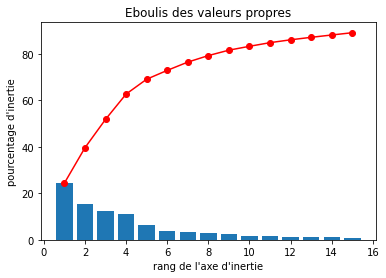

In [81]:
# features pour l'analyse (hors features targets et Energy Star Score)
features = data_final.columns[~data_final.columns.isin(['New_SiteEUIWN(kBtu/sf)', 'New_GHGEmissionsIntensity',
                                                        'ENERGYSTARScore'])]

# colonnes à centrer / réduire
col_std = ['CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 
           'NumberofFloors', 'New_PropertyGFATotal']

# choix du nombre de composantes à calculer
n_comp = 15

# préparation des données pour l'ACP
X = data_final[features]

# Ne standardisons que les variables qui en ont besoin
X_std = X.copy()
for col in col_std:
    mean = X[col].mean()
    std = X[col].std()
    X_std[col] = (X[col]-mean) / std

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_std)

# Eboulis des valeurs propres
display_scree_plot(pca)

In [82]:
# Les 6 premières composantes expliquent 70% de la variabilité, ne gardons que 6 composantes pour la suite
n_comp = 6

# District de l'immeuble
district = [X.loc[grade_id, 'CouncilDistrictCode'] for grade_id in X.index]

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_std)

# Corrélations et projections
pcs = pca.components_
X_projected = pca.transform(X_std)

# Créer un tableau récapitulatif des composantes
acp_compo = pd.DataFrame(columns = ['features','F1','F2','F3','F4','F5','F6'])
acp_compo['features'] = features
acp_compo['F1'] = pca.components_.transpose()[:,0]
acp_compo['F2'] = pca.components_.transpose()[:,1]
acp_compo['F3'] = pca.components_.transpose()[:,2]
acp_compo['F4'] = pca.components_.transpose()[:,3]
acp_compo['F5'] = pca.components_.transpose()[:,4]
acp_compo['F6'] = pca.components_.transpose()[:,5]
acp_compo

,features,F1,F2,F3,F4,F5,F6
0,CouncilDistrictCode,0.6083,-0.1532,-0.0507,0.0289,0.0162,-0.5146
1,Latitude,0.4822,-0.1998,-0.4633,0.3126,0.2633,0.2162
2,Longitude,-0.3018,0.1826,-0.0347,0.8725,-0.0165,-0.2336
3,YearBuilt,-0.0407,0.4725,-0.7132,-0.1712,-0.4460,-0.0679
4,NumberofFloors,0.4348,0.3668,0.4264,0.1799,-0.4482,0.3386
...,...,...,...,...,...,...,...
103,Neighbor_NORTH,0.0170,-0.0104,-0.0530,0.0628,0.0198,0.0106
104,Neighbor_NORTHEAST,0.0064,0.0054,-0.0551,0.1246,0.0414,0.0391
105,Neighbor_NORTHWEST,0.0342,-0.0237,-0.0748,0.0121,0.0543,0.0636
106,Neighbor_SOUTHEAST,-0.0272,0.0205,-0.0034,0.0395,-0.0217,0.0013


In [83]:
# Regardons les features qui ont une forte corrélation pour chaque composante

for col in acp_compo.columns[1:]:
    print(col, ':')
    mask  = acp_compo[col].abs() > 0.4
    print(acp_compo.loc[mask, ['features', col]])
    print(50*'-')

F1 :
              features     F1
0  CouncilDistrictCode 0.6083
1             Latitude 0.4822
4       NumberofFloors 0.4348
--------------------------------------------------
F2 :
               features     F2
3             YearBuilt 0.4725
9  New_PropertyGFATotal 0.7219
--------------------------------------------------
F3 :
         features      F3
1        Latitude -0.4633
3       YearBuilt -0.7132
4  NumberofFloors  0.4264
--------------------------------------------------
F4 :
    features     F4
2  Longitude 0.8725
--------------------------------------------------
F5 :
               features      F5
3             YearBuilt -0.4460
4        NumberofFloors -0.4482
9  New_PropertyGFATotal  0.6117
--------------------------------------------------
F6 :
              features      F6
0  CouncilDistrictCode -0.5146
--------------------------------------------------


La composante F1 est représente la localisation de l'immeuble (en fonction des Districts et de la latitude), et elle est également liée au nombre d'étage, ce qui peut laisser penser que la hauteur des immeubles dépend du quartier ce qui est logique. A priori, plus on va vers le district 7 plus les immeubles sont hauts.

La composante F2 quant à elle est liée positivement à la surface totale et à l'année de construction. Cela laisse à penser que les immeubles les plus grands (en surface) sont les plus récents.

La composante F3 lie l'age de l'immeuble et son nombre d'étage à sa localisation. Plus un immeuble est récent, plus il aura tendance à être situé dans un quartier précis, et moins il aura tendance à avoir un nombre d'étage élevé.

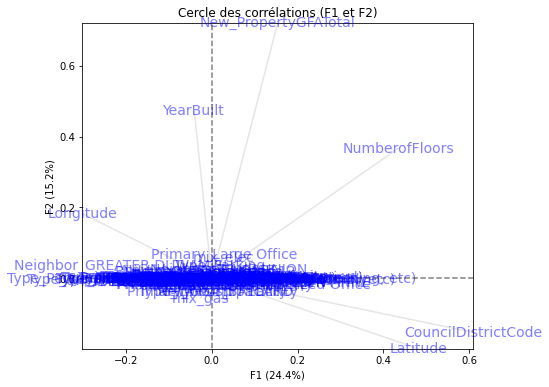

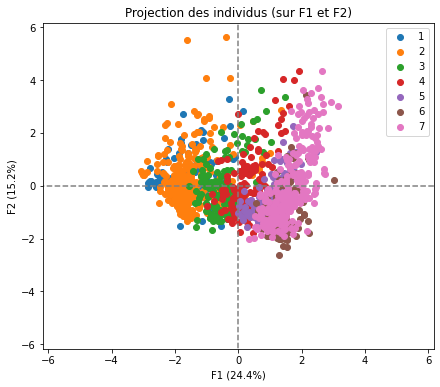

In [84]:
# Affichons les composantes F1 et F2
# Cercle des corrélations
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))
# Projection des individus par nutrigrade
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],illustrative_var = district)

On visualise bien ici les différents districts. Même s'il semble qu'il y ait plus de grands immeubles dans le district 7, la taille des immeubles semble relativement bien répartis dans les différents districts.

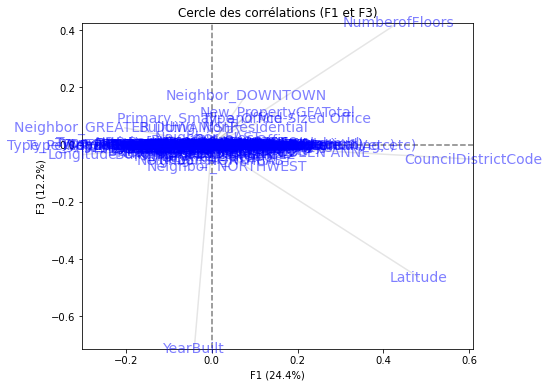

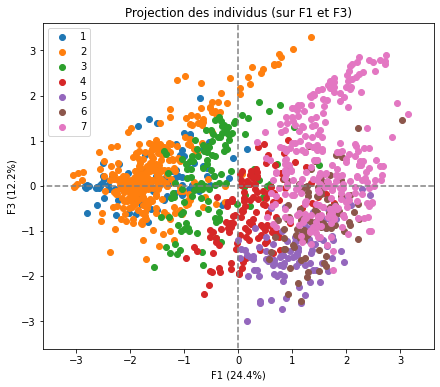

In [85]:
# Affichons les composantes F1 et F3
# Cercle des corrélations
display_circles(pcs, n_comp, pca, [(0,2)], labels = np.array(features))
# Projection des individus par nutrigrade
display_factorial_planes(X_projected, n_comp, pca, [(0,2)],illustrative_var = district)

Ici on peut voir quels sont les districts qui contiennent les immeubles les plus récents et moins élevé (principalement 4, 5 et 6) et ceux qui contiennent les immeubles les plus vieux et hauts (principalement 2, 3 et 7).

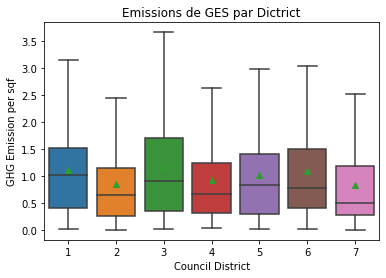

In [120]:
# Analyse des émissions de GES par District
sns.boxplot(x='CouncilDistrictCode', y='New_GHGEmissionsIntensity', data=data_final, showfliers = False, showmeans = True)
plt.xlabel('Council District')
plt.ylabel('GHG Emission per sqf')
plt.title('Emissions de GES par Dictrict')
plt.show()

On peut voir grâce aux boxplots que les districts 2, 4 et 7 sont les plus vertueux en terme d'émissions de GES. Ils sont également parmis les meilleurs au niveau de la consommation d'énergie.

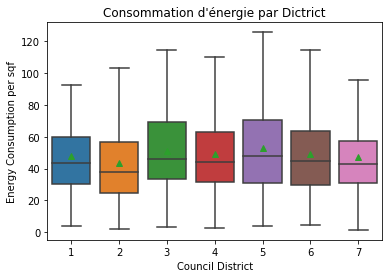

In [121]:
# Analyse de la consommation d'énergie par district
sns.boxplot(x='CouncilDistrictCode', y='New_SiteEUIWN(kBtu/sf)', data=data_final, showfliers = False, showmeans = True)
plt.xlabel('Council District')
plt.ylabel('Energy Consumption per sqf')
plt.title("Consommation d'énergie par Dictrict")
plt.show()